# For fine-tune

## Install requirements

In [2]:
from IPython.display import clear_output

In [4]:
!pip install yfinance
!pip install fix_yahoo_finance
!pip install pymoo
clear_output()

In [5]:
# Load Packages
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
%matplotlib inline

## Fine tune data

In [7]:
# Import yfinance package
import yfinance as yf

# Set the start and end date
start_date = '2020-04-30' #'2020-04-30'
end_date = '2024-04-30'   #'2024-04-30'

ticker = ['AAPL', 'NVDA', 'MSFT', 'AMZN', 'META', 'GOOGL', 'TSLA', 'AVGO', 'GOOG', 'BRK-B',
          'JPM', 'LLY', 'V', 'XOM', 'UNH', 'MA', 'COST', 'WMT', 'HD', 'PG',
          'NFLX', 'JNJ', 'ABBV', 'CRM', 'BAC', 'ORCL', 'MRK', 'CVX', 'WFC', 'KO',
          'CSCO', 'ACN', 'NOW', 'TMO', 'MCD', 'IBM', 'AMD', 'DIS', 'PEP', 'LIN',
          'ABT', 'ISRG', 'PM', 'GE', 'ADBE', 'GS', 'QCOM', 'TXN', 'CAT', 'INTU']

# Get the data
fine_tune_data = yf.download(ticker, start_date, end_date, auto_adjust=False) # adding auto_adjust=False to get Adj Close

[*********************100%***********************]  50 of 50 completed


In [8]:
fine_tune_data = fine_tune_data['Adj Close']
fine_tune_data

import numpy as np
# Log of percentage change
cov_matrix = fine_tune_data.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix

# Yearly returns for individual companies
ind_er = fine_tune_data.resample('YE').last().pct_change().mean()
ind_er

mu = np.array(ind_er)
cov = np.array(cov_matrix)

### Run the experiment HV

In [14]:
### Test HV index

In [16]:
# import libs
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import operator

class PortfolioProblem(ElementwiseProblem):
    def __init__(self, mu, cov, risk_free_rate=0.02, **kwargs):
        super().__init__(n_var=len(np.array(ticker)), n_obj=2, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
        self.risk_free_rate = risk_free_rate

    def _evaluate(self, x, out, *args, **kwargs):
        exp_return = x @ self.mu
        exp_risk = np.sqrt(x.T @ self.cov @ x) * np.sqrt(250.0)
        sharpe = (exp_return - self.risk_free_rate) / exp_risk

        out["F"] = [exp_risk, -exp_return]
        out["sharpe"] = sharpe

In [18]:
class PortfolioRepair(Repair):
    def _do(self, problem, X, **kwargs):
        X[X < 1e-3] = 0
        return X / X.sum(axis=1, keepdims=True)

In [20]:
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.sampling.rnd import FloatRandomSampling, BinaryRandomSampling
from pymoo.operators.sampling.lhs import LHS
from pymoo.optimize import minimize
from pymoo.indicators.hv import HV

# Define configurations combining sampling and crossover operators
configurations = [
    {'name': 'BinaryRandom_SBX',   'sampling': BinaryRandomSampling(), 'crossover': SBX()},
    {'name': 'BinaryRandom_TwoPt', 'sampling': BinaryRandomSampling(), 'crossover': TwoPointCrossover()},
    {'name': 'BinaryRandom_Uniform','sampling': BinaryRandomSampling(), 'crossover': UniformCrossover()},

    {'name': 'FloatRandom_SBX',    'sampling': FloatRandomSampling(),  'crossover': SBX()},
    {'name': 'FloatRandom_TwoPt',  'sampling': FloatRandomSampling(),  'crossover': TwoPointCrossover()},
    {'name': 'FloatRandom_Uniform','sampling': FloatRandomSampling(),  'crossover': UniformCrossover()},

    {'name': 'LHS_SBX',            'sampling': LHS(),               'crossover': SBX()},
    {'name': 'LHS_TwoPt',          'sampling': LHS(),               'crossover': TwoPointCrossover()},
    {'name': 'LHS_Uniform',        'sampling': LHS(),               'crossover': UniformCrossover()},
]

In [30]:
import matplotlib.pyplot as plt

def calculate_HV(F):
    """Calculate hypervolume of the front F against a fixed reference point."""
    ref_point = np.array([0.55, -0.05])
    ind = HV(ref_point=ref_point)

    plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Pareto-Optimal Portfolio")
    plt.scatter(ref_point[0], ref_point[1], facecolor="none", edgecolors="green", alpha=0.5, label="reference point")
    plt.legend()
    plt.xlabel("expected volatility")
    plt.ylabel("expected return")
    plt.show()
   
    return ind(F)

Run 1/10 - BinaryRandom_SBX - 500 gens


  Hypervolume@500: 0.285125
Run 1/10 - BinaryRandom_SBX - 600 gens


  Hypervolume@600: 0.285122

Run 1/10 - BinaryRandom_TwoPt - 500 gens


  Hypervolume@500: 0.285069
Run 1/10 - BinaryRandom_TwoPt - 600 gens


  Hypervolume@600: 0.285089

Run 1/10 - BinaryRandom_Uniform - 500 gens


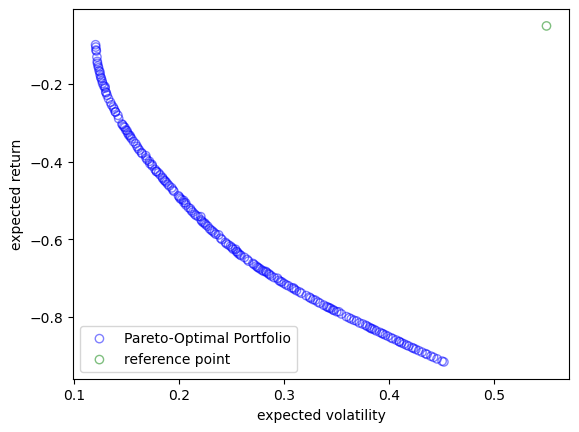

  Hypervolume@500: 0.281133
Run 1/10 - BinaryRandom_Uniform - 600 gens


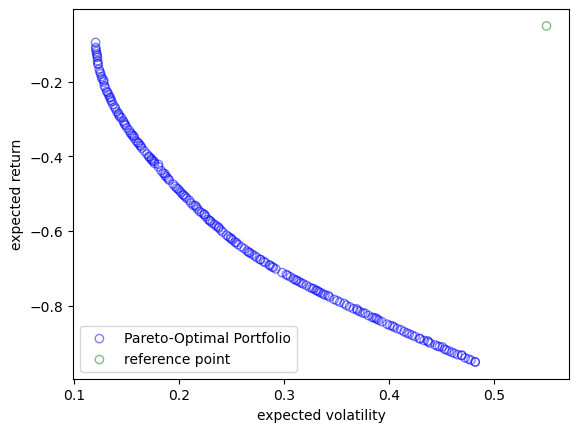

  Hypervolume@600: 0.283882

Run 1/10 - FloatRandom_SBX - 500 gens


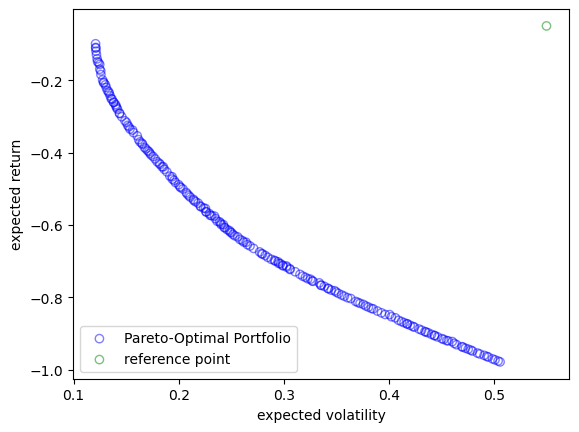

  Hypervolume@500: 0.285030
Run 1/10 - FloatRandom_SBX - 600 gens


  Hypervolume@600: 0.285051

Run 1/10 - FloatRandom_TwoPt - 500 gens


  Hypervolume@500: 0.285024
Run 1/10 - FloatRandom_TwoPt - 600 gens


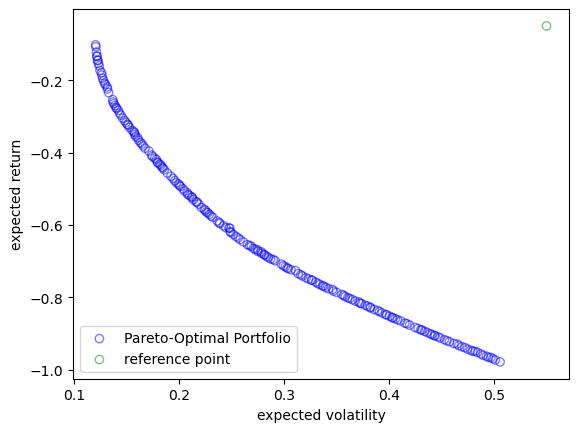

  Hypervolume@600: 0.285113

Run 1/10 - FloatRandom_Uniform - 500 gens


  Hypervolume@500: 0.284992
Run 1/10 - FloatRandom_Uniform - 600 gens


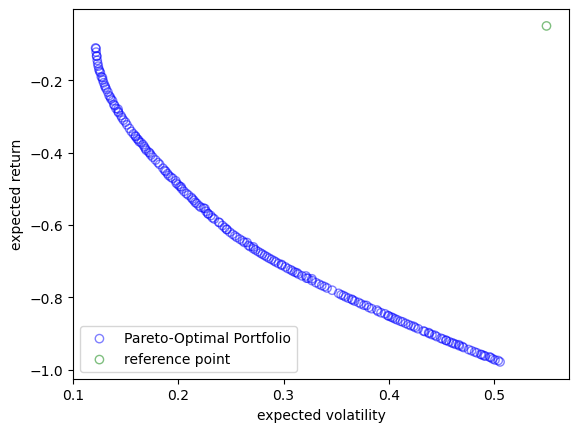

  Hypervolume@600: 0.285274

Run 1/10 - LHS_SBX - 500 gens


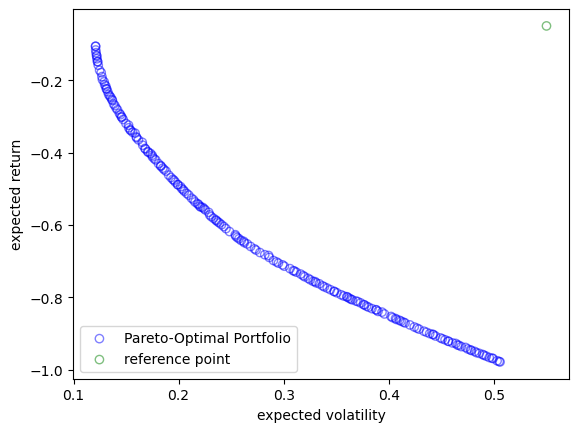

  Hypervolume@500: 0.285113
Run 1/10 - LHS_SBX - 600 gens


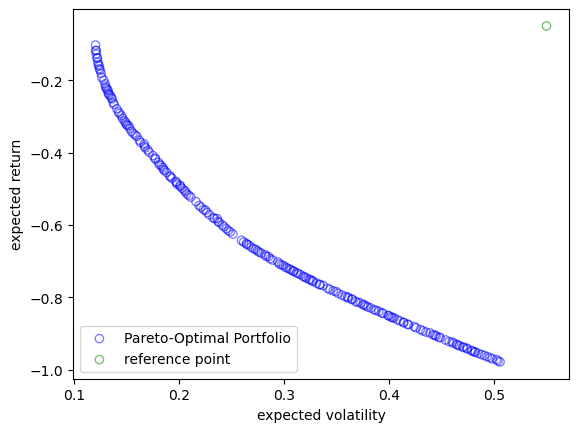

  Hypervolume@600: 0.285150

Run 1/10 - LHS_TwoPt - 500 gens


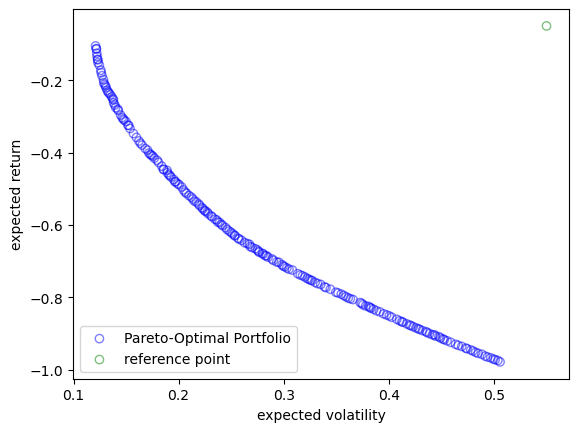

  Hypervolume@500: 0.285008
Run 1/10 - LHS_TwoPt - 600 gens


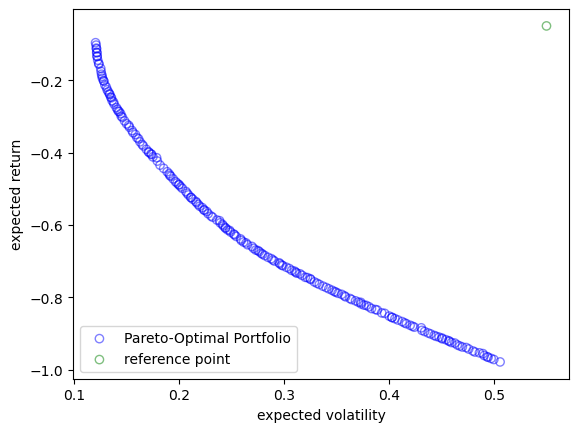

  Hypervolume@600: 0.285004

Run 1/10 - LHS_Uniform - 500 gens


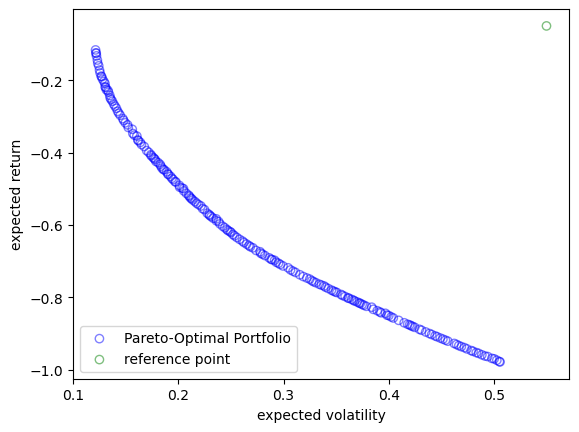

  Hypervolume@500: 0.285254
Run 1/10 - LHS_Uniform - 600 gens


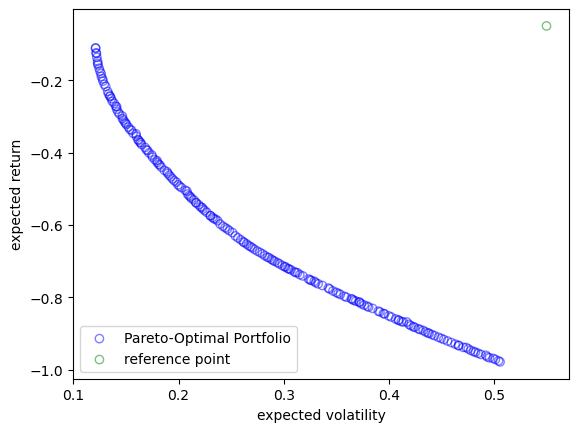

  Hypervolume@600: 0.285211

Run 2/10 - BinaryRandom_SBX - 500 gens


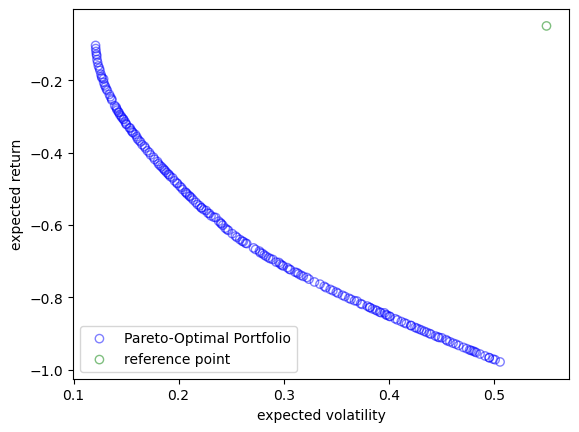

  Hypervolume@500: 0.285171
Run 2/10 - BinaryRandom_SBX - 600 gens


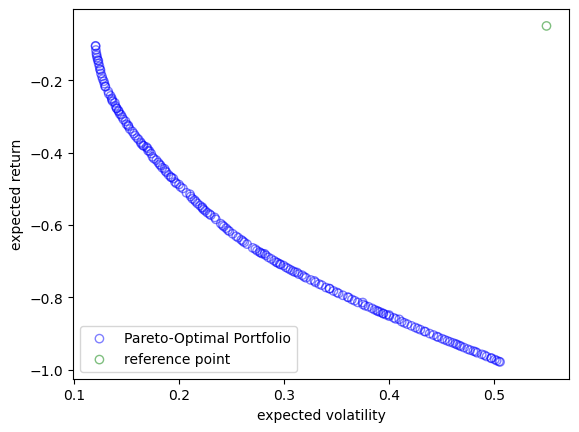

  Hypervolume@600: 0.285121

Run 2/10 - BinaryRandom_TwoPt - 500 gens


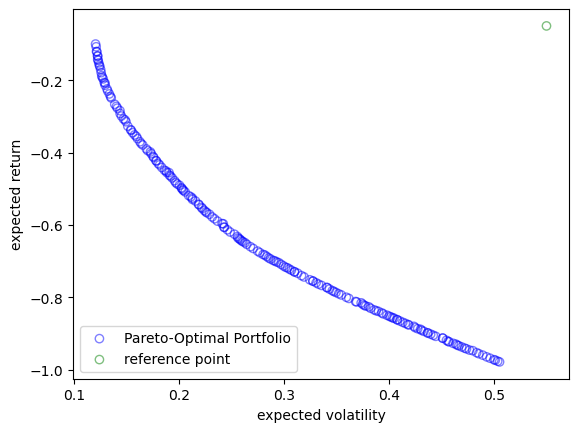

  Hypervolume@500: 0.285144
Run 2/10 - BinaryRandom_TwoPt - 600 gens


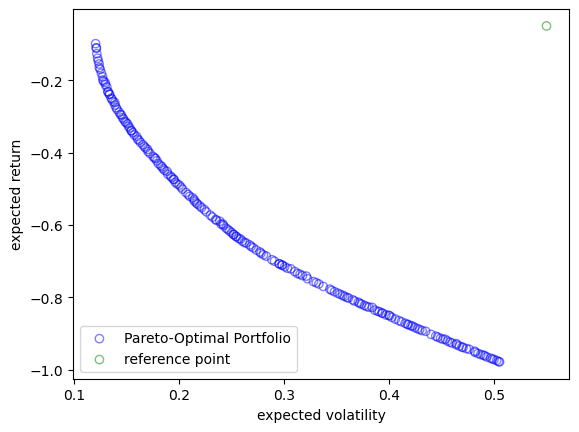

  Hypervolume@600: 0.285144

Run 2/10 - BinaryRandom_Uniform - 500 gens


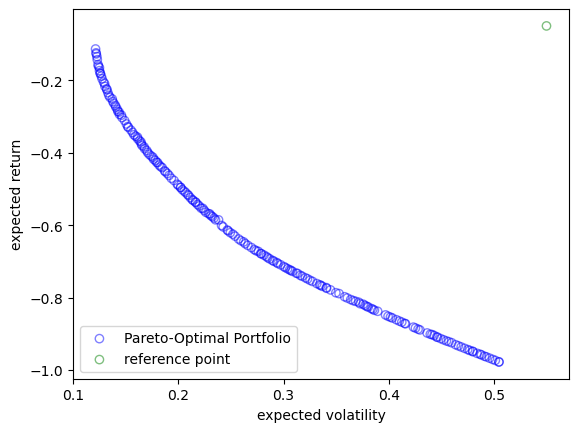

  Hypervolume@500: 0.285161
Run 2/10 - BinaryRandom_Uniform - 600 gens


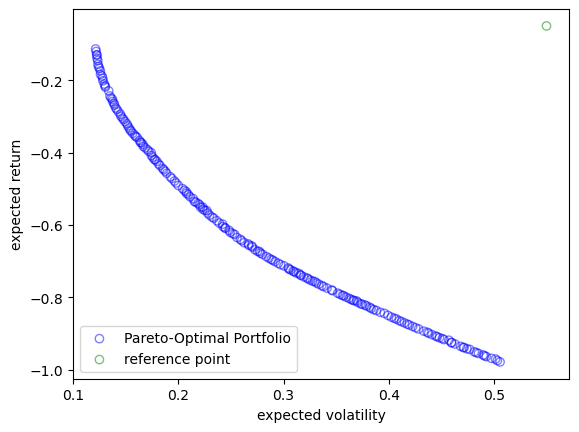

  Hypervolume@600: 0.285124

Run 2/10 - FloatRandom_SBX - 500 gens


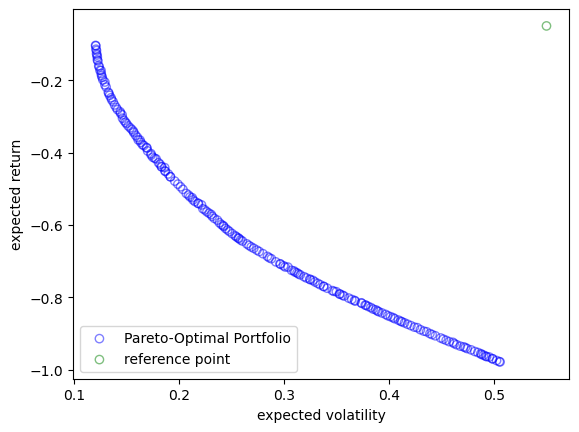

  Hypervolume@500: 0.285100
Run 2/10 - FloatRandom_SBX - 600 gens


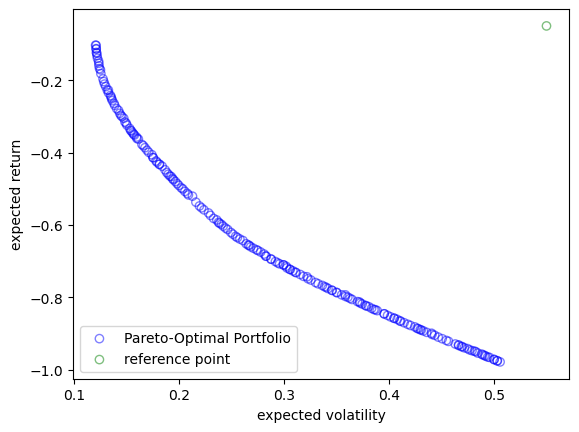

  Hypervolume@600: 0.285137

Run 2/10 - FloatRandom_TwoPt - 500 gens


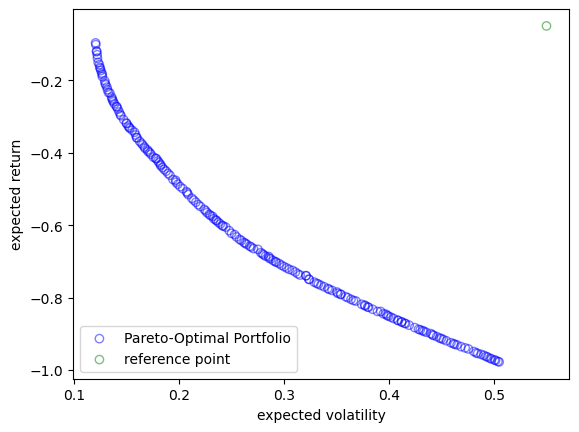

  Hypervolume@500: 0.285005
Run 2/10 - FloatRandom_TwoPt - 600 gens


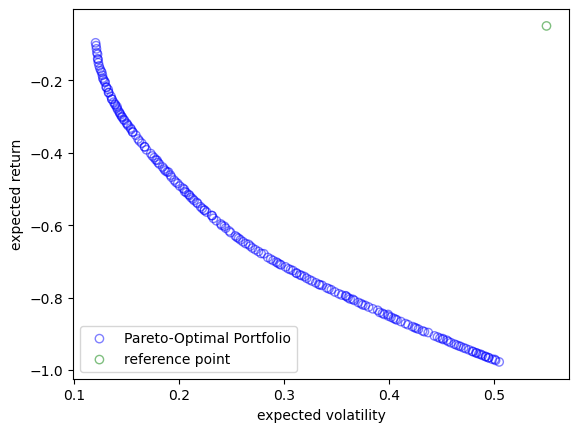

  Hypervolume@600: 0.285080

Run 2/10 - FloatRandom_Uniform - 500 gens


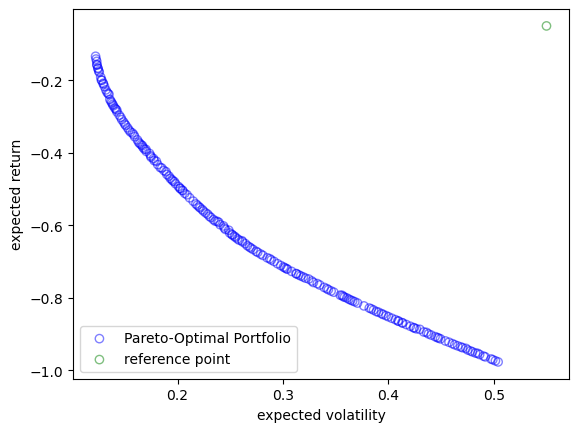

  Hypervolume@500: 0.285133
Run 2/10 - FloatRandom_Uniform - 600 gens


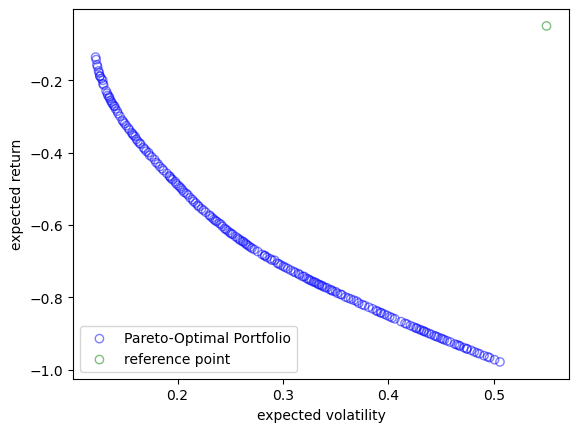

  Hypervolume@600: 0.285291

Run 2/10 - LHS_SBX - 500 gens


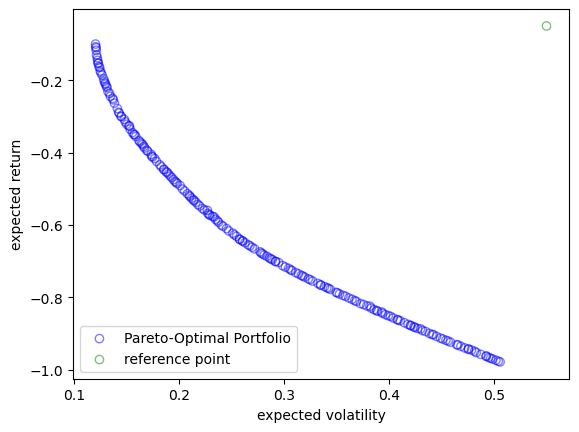

  Hypervolume@500: 0.285179
Run 2/10 - LHS_SBX - 600 gens


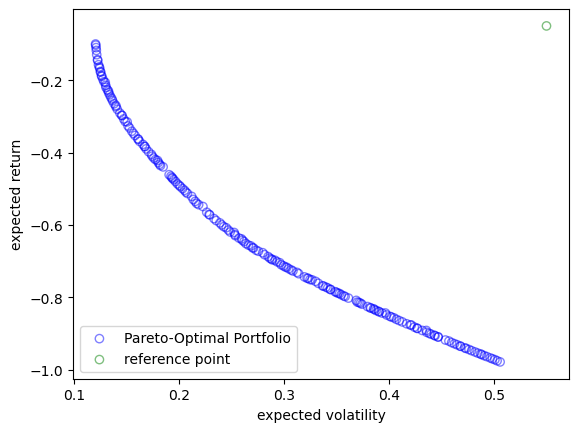

  Hypervolume@600: 0.285099

Run 2/10 - LHS_TwoPt - 500 gens


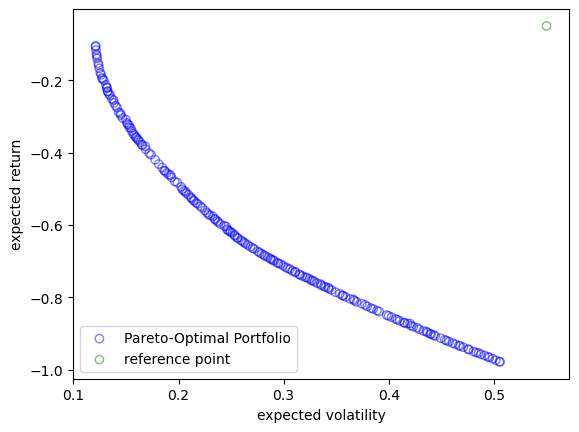

  Hypervolume@500: 0.285060
Run 2/10 - LHS_TwoPt - 600 gens


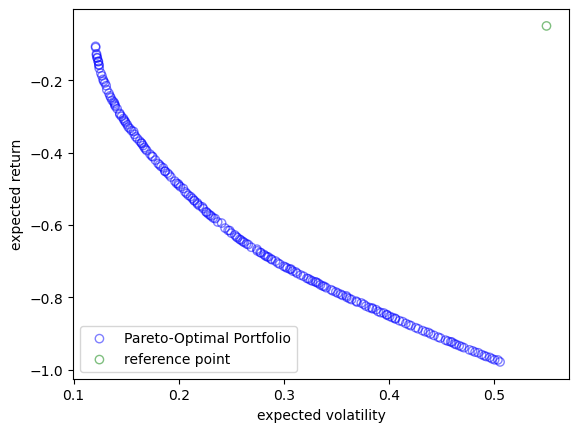

  Hypervolume@600: 0.285175

Run 2/10 - LHS_Uniform - 500 gens


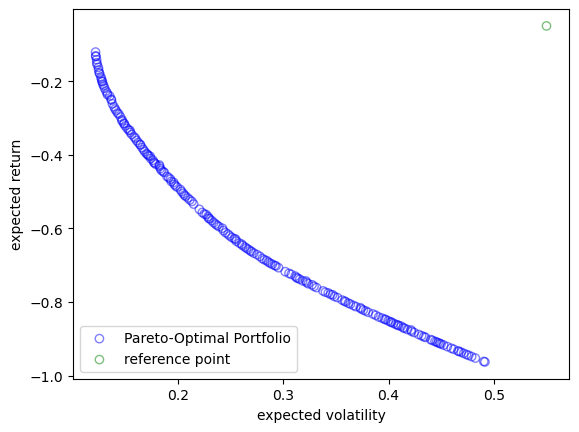

  Hypervolume@500: 0.284394
Run 2/10 - LHS_Uniform - 600 gens


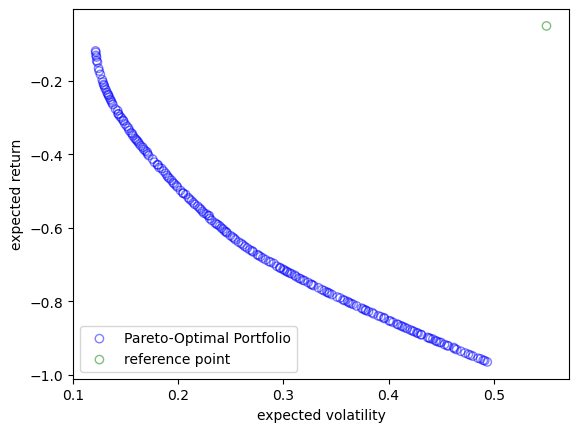

  Hypervolume@600: 0.284674

Run 3/10 - BinaryRandom_SBX - 500 gens


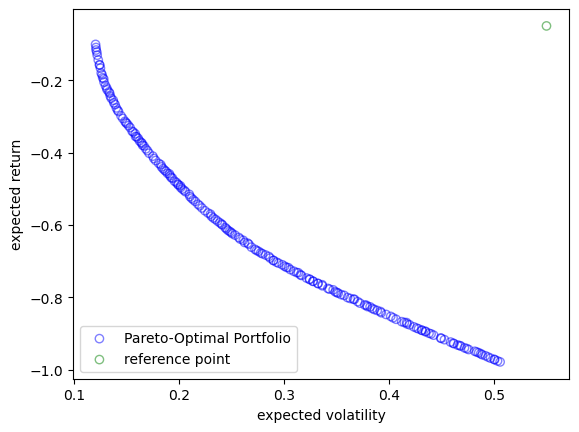

  Hypervolume@500: 0.285161
Run 3/10 - BinaryRandom_SBX - 600 gens


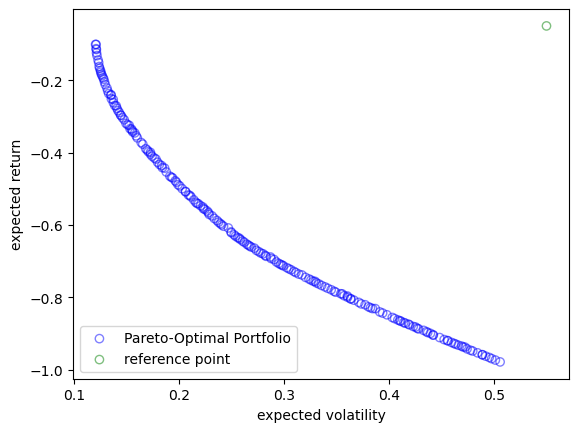

  Hypervolume@600: 0.285132

Run 3/10 - BinaryRandom_TwoPt - 500 gens


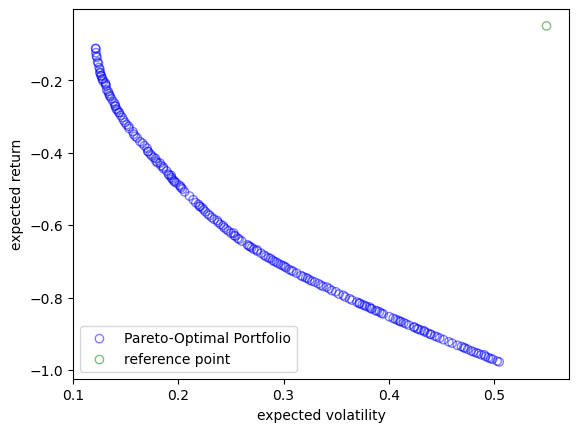

  Hypervolume@500: 0.285001
Run 3/10 - BinaryRandom_TwoPt - 600 gens


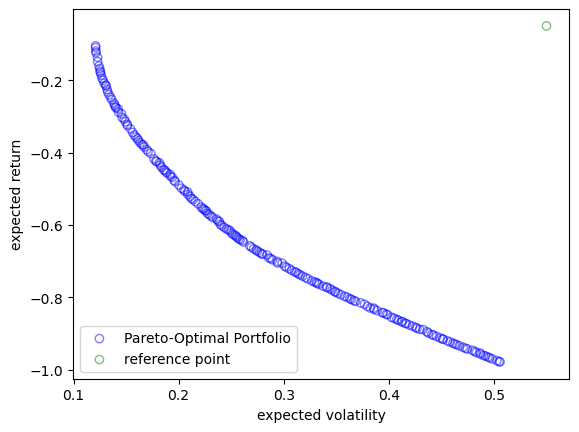

  Hypervolume@600: 0.285103

Run 3/10 - BinaryRandom_Uniform - 500 gens


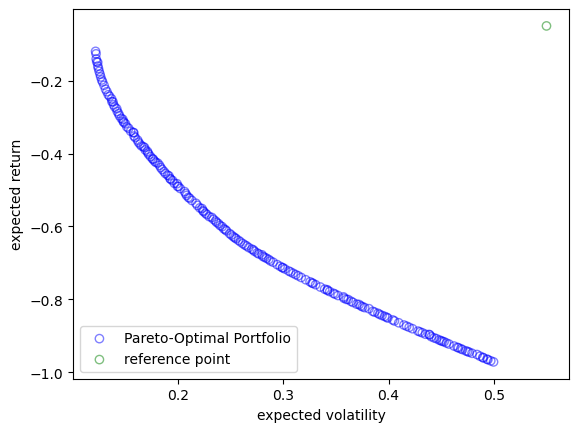

  Hypervolume@500: 0.284972
Run 3/10 - BinaryRandom_Uniform - 600 gens


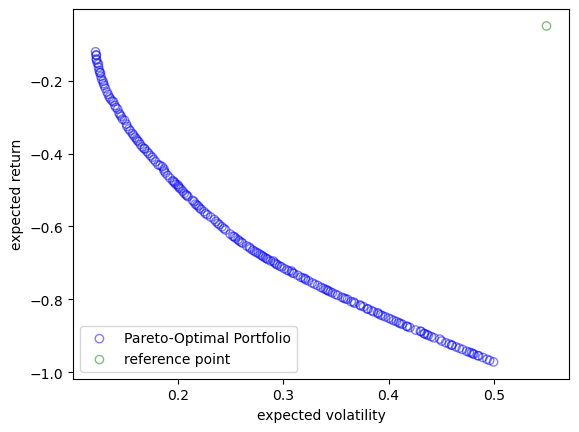

  Hypervolume@600: 0.284903

Run 3/10 - FloatRandom_SBX - 500 gens


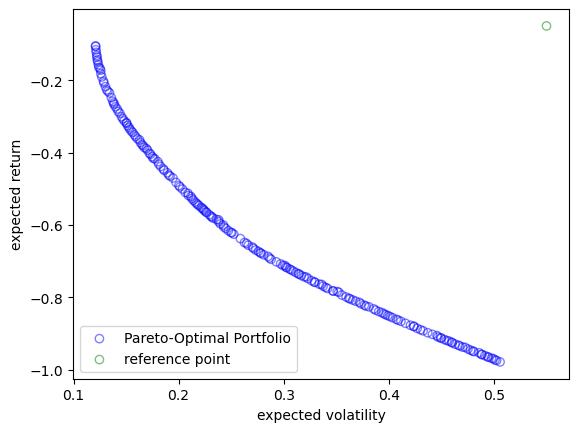

  Hypervolume@500: 0.285148
Run 3/10 - FloatRandom_SBX - 600 gens


  Hypervolume@600: 0.285180

Run 3/10 - FloatRandom_TwoPt - 500 gens


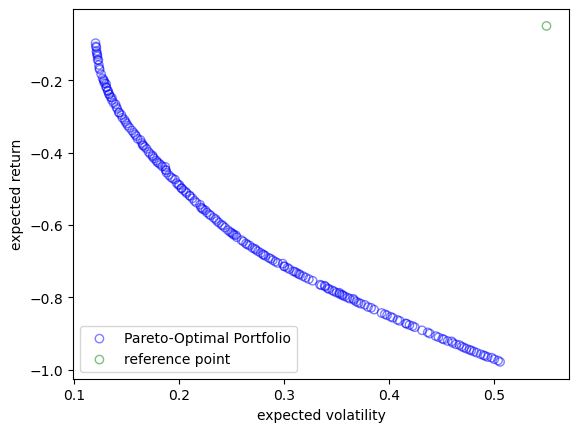

  Hypervolume@500: 0.285133
Run 3/10 - FloatRandom_TwoPt - 600 gens


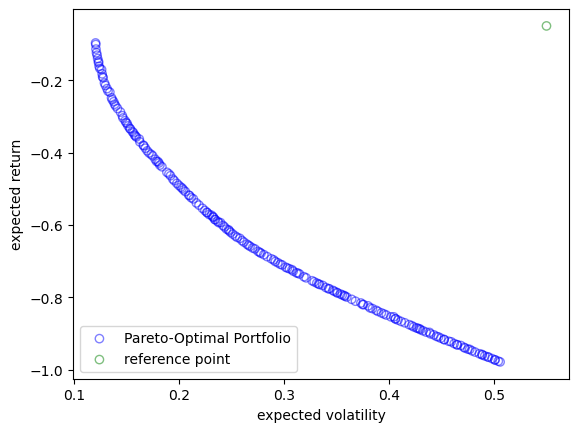

  Hypervolume@600: 0.285153

Run 3/10 - FloatRandom_Uniform - 500 gens


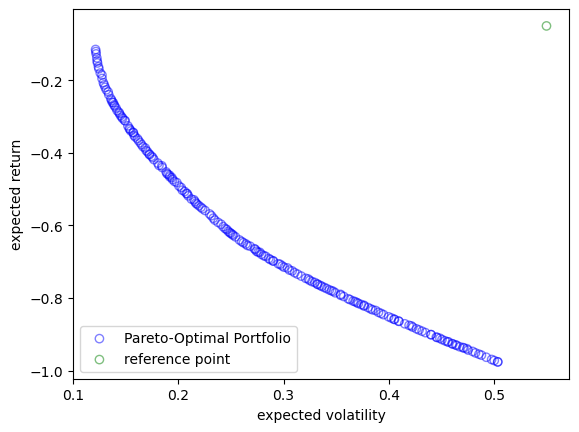

  Hypervolume@500: 0.285040
Run 3/10 - FloatRandom_Uniform - 600 gens


  Hypervolume@600: 0.285133

Run 3/10 - LHS_SBX - 500 gens


  Hypervolume@500: 0.285147
Run 3/10 - LHS_SBX - 600 gens


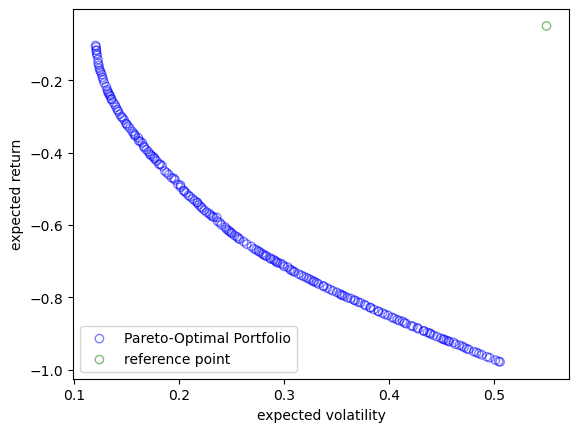

  Hypervolume@600: 0.285163

Run 3/10 - LHS_TwoPt - 500 gens


  Hypervolume@500: 0.285009
Run 3/10 - LHS_TwoPt - 600 gens


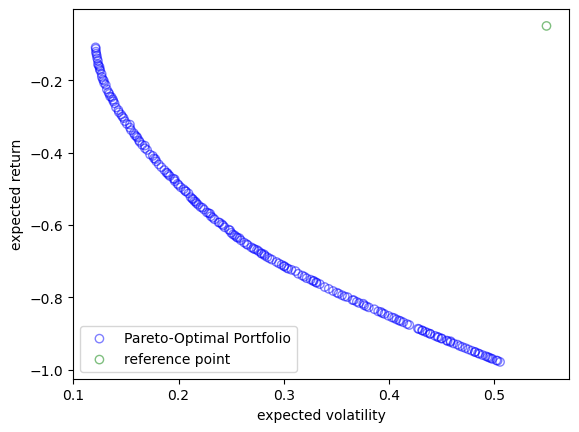

  Hypervolume@600: 0.285076

Run 3/10 - LHS_Uniform - 500 gens


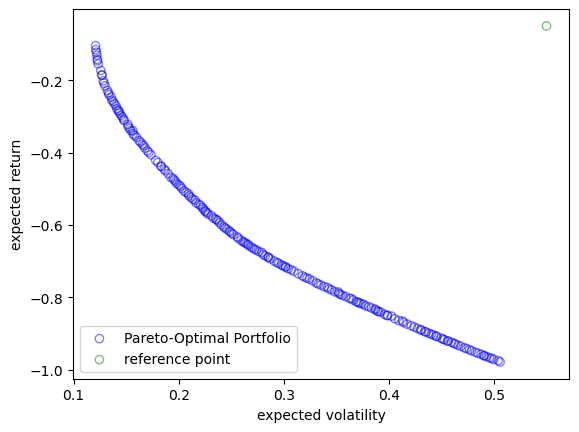

  Hypervolume@500: 0.285195
Run 3/10 - LHS_Uniform - 600 gens


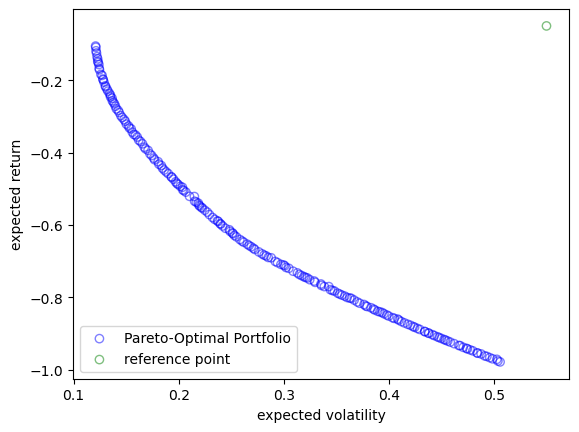

  Hypervolume@600: 0.285164

Run 4/10 - BinaryRandom_SBX - 500 gens


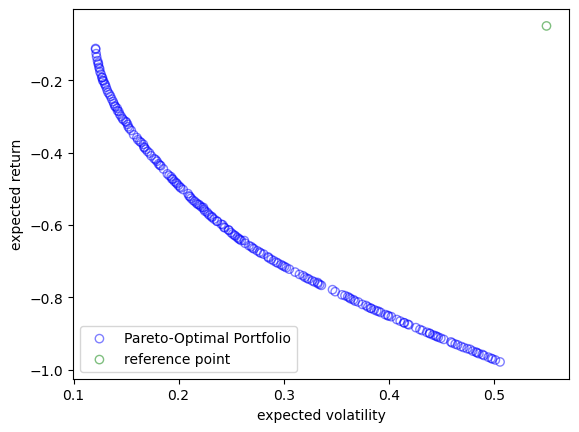

  Hypervolume@500: 0.285161
Run 4/10 - BinaryRandom_SBX - 600 gens


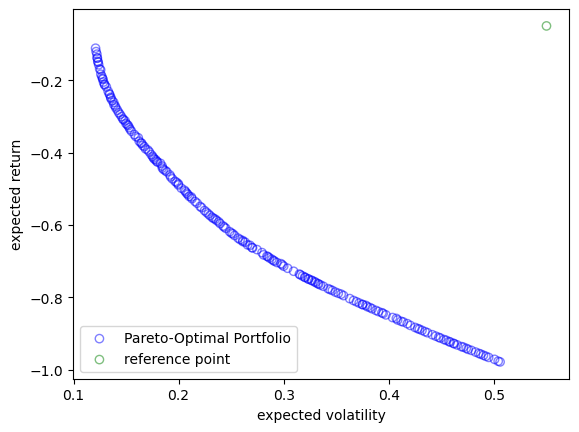

  Hypervolume@600: 0.285182

Run 4/10 - BinaryRandom_TwoPt - 500 gens


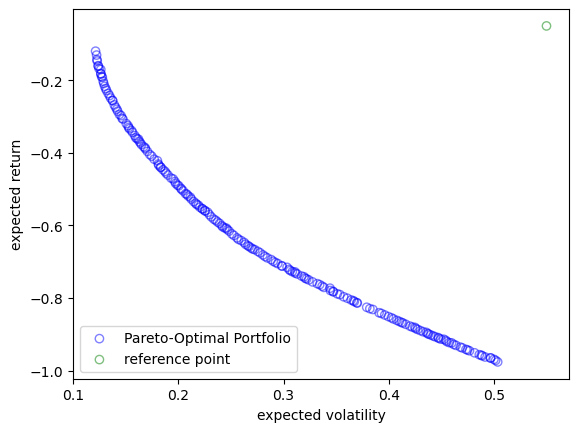

  Hypervolume@500: 0.285022
Run 4/10 - BinaryRandom_TwoPt - 600 gens


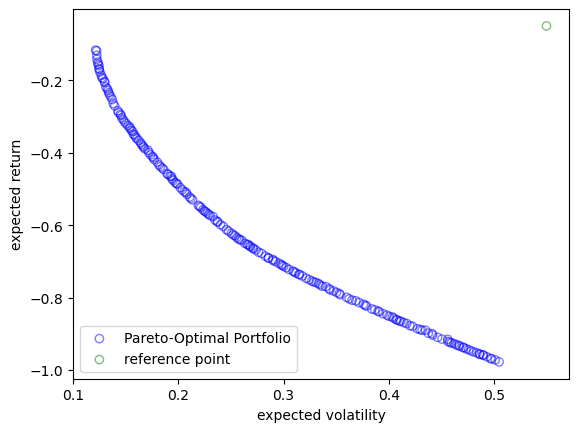

  Hypervolume@600: 0.285064

Run 4/10 - BinaryRandom_Uniform - 500 gens


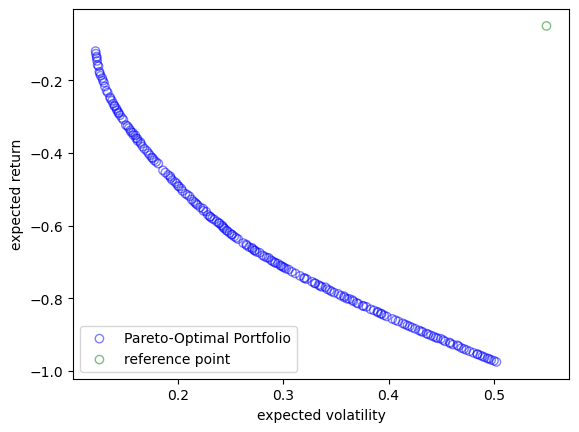

  Hypervolume@500: 0.285014
Run 4/10 - BinaryRandom_Uniform - 600 gens


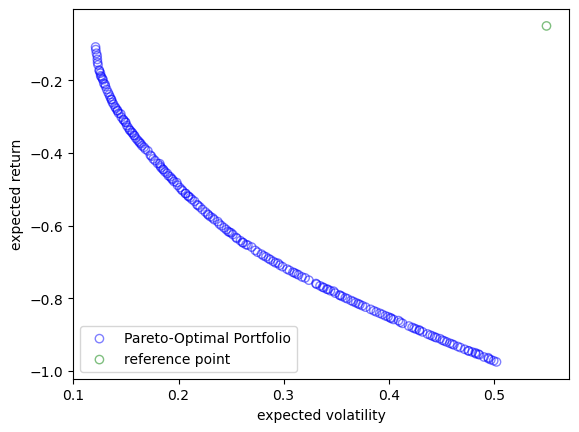

  Hypervolume@600: 0.285159

Run 4/10 - FloatRandom_SBX - 500 gens


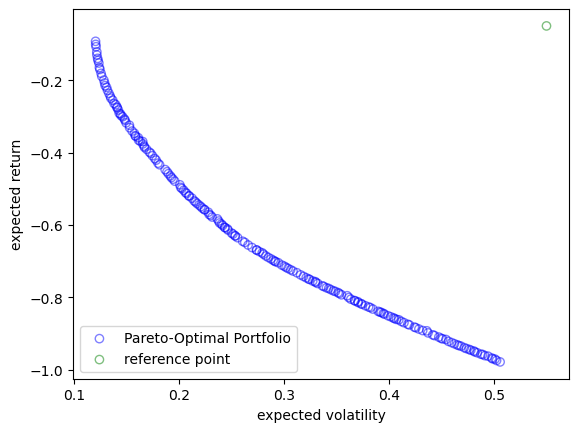

  Hypervolume@500: 0.285179
Run 4/10 - FloatRandom_SBX - 600 gens


  Hypervolume@600: 0.285111

Run 4/10 - FloatRandom_TwoPt - 500 gens


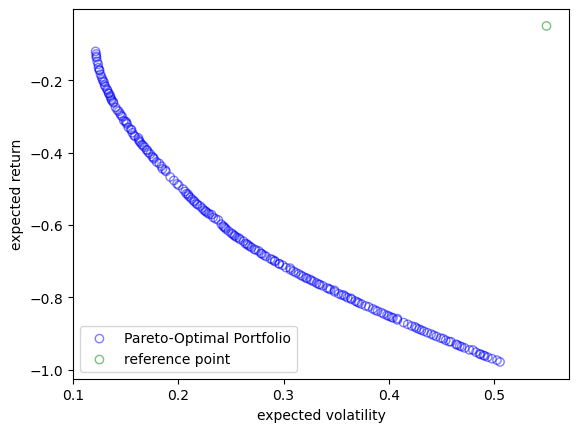

  Hypervolume@500: 0.285128
Run 4/10 - FloatRandom_TwoPt - 600 gens


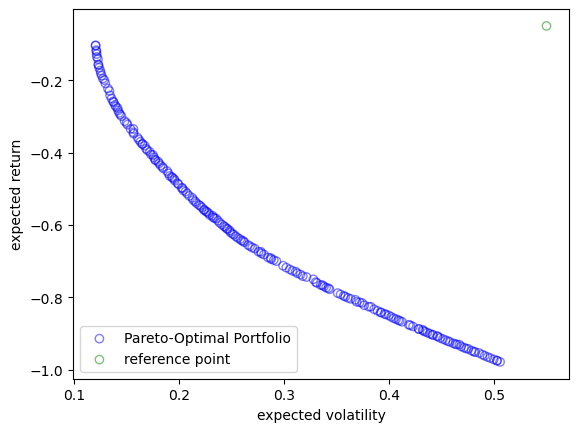

  Hypervolume@600: 0.285016

Run 4/10 - FloatRandom_Uniform - 500 gens


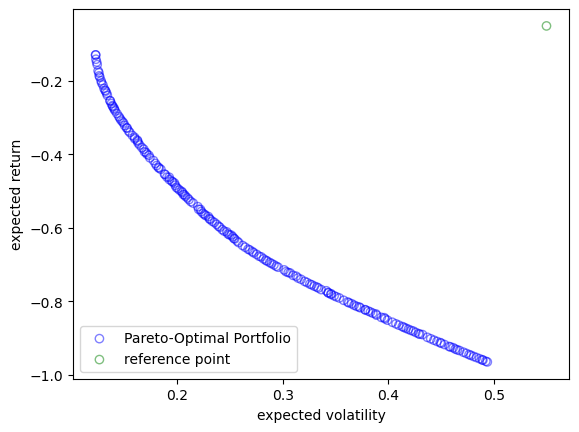

  Hypervolume@500: 0.284477
Run 4/10 - FloatRandom_Uniform - 600 gens


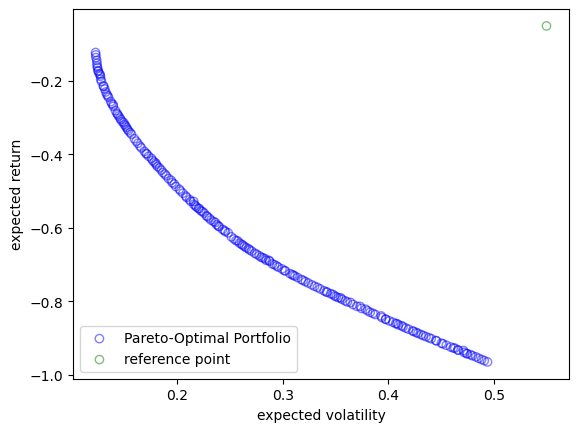

  Hypervolume@600: 0.284620

Run 4/10 - LHS_SBX - 500 gens


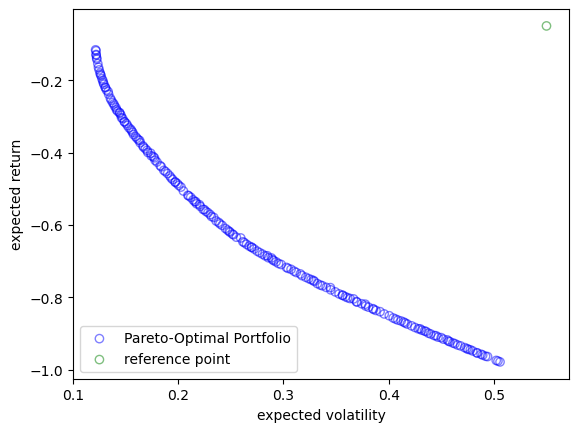

  Hypervolume@500: 0.285059
Run 4/10 - LHS_SBX - 600 gens


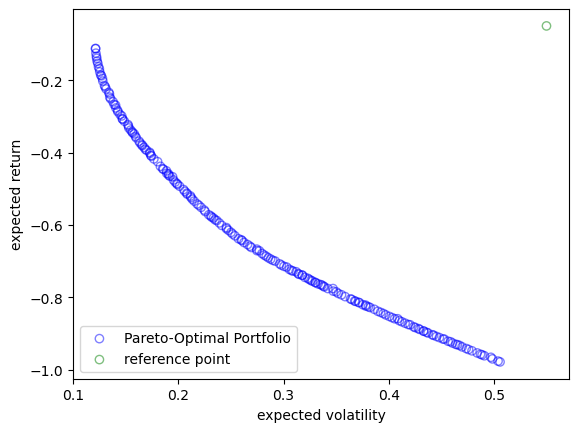

  Hypervolume@600: 0.285158

Run 4/10 - LHS_TwoPt - 500 gens


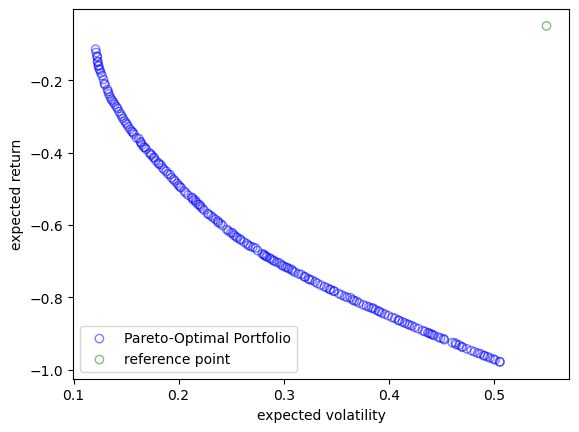

  Hypervolume@500: 0.285137
Run 4/10 - LHS_TwoPt - 600 gens


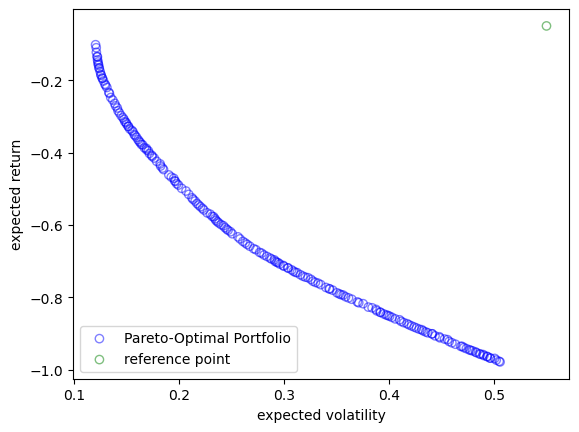

  Hypervolume@600: 0.285160

Run 4/10 - LHS_Uniform - 500 gens


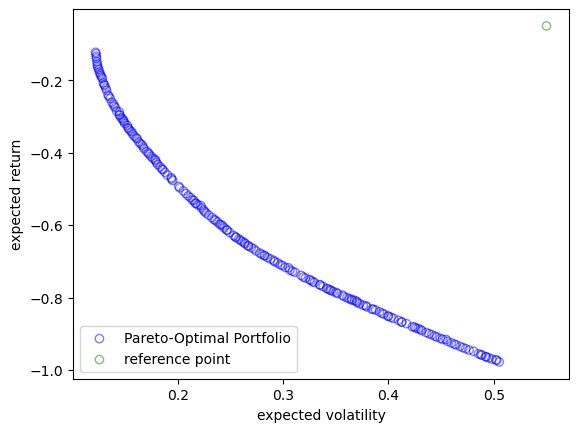

  Hypervolume@500: 0.285119
Run 4/10 - LHS_Uniform - 600 gens


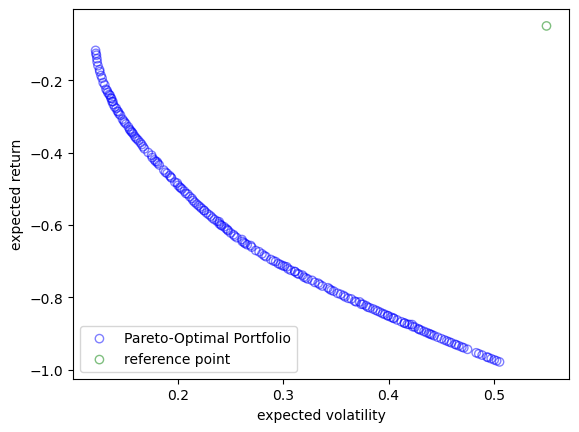

  Hypervolume@600: 0.285166

Run 5/10 - BinaryRandom_SBX - 500 gens


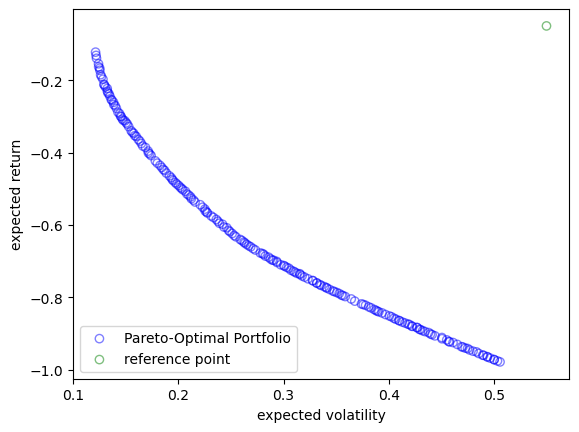

  Hypervolume@500: 0.285091
Run 5/10 - BinaryRandom_SBX - 600 gens


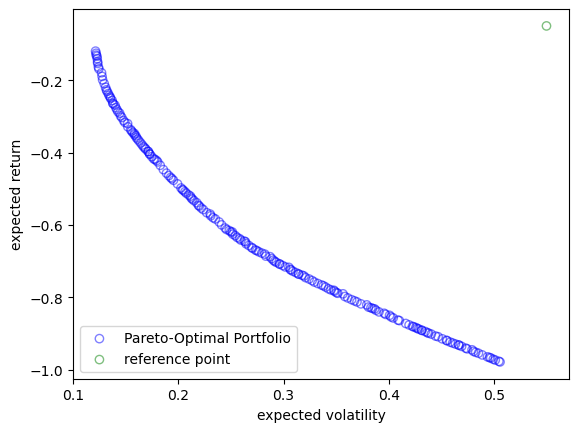

  Hypervolume@600: 0.285134

Run 5/10 - BinaryRandom_TwoPt - 500 gens


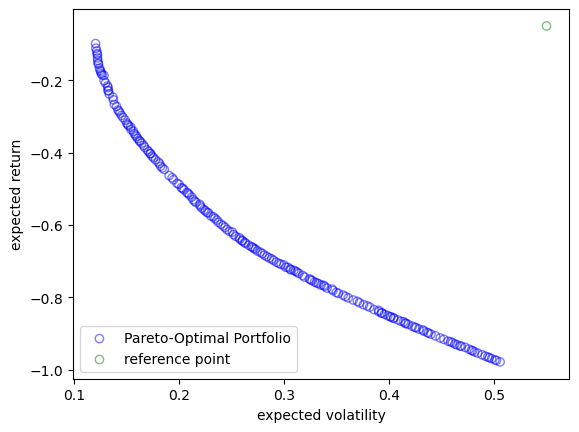

  Hypervolume@500: 0.285083
Run 5/10 - BinaryRandom_TwoPt - 600 gens


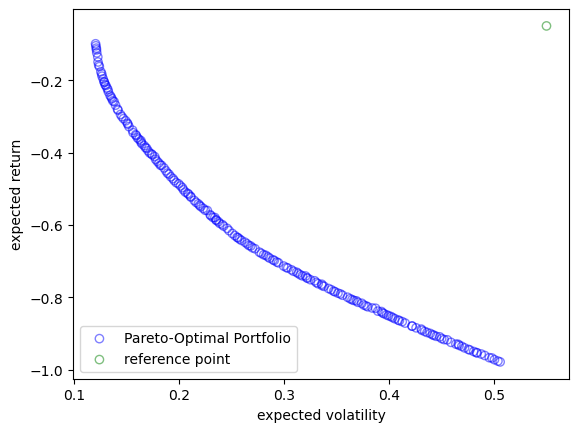

  Hypervolume@600: 0.285149

Run 5/10 - BinaryRandom_Uniform - 500 gens


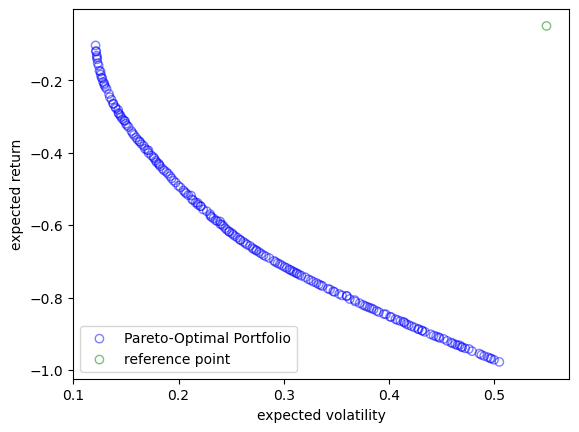

  Hypervolume@500: 0.285250
Run 5/10 - BinaryRandom_Uniform - 600 gens


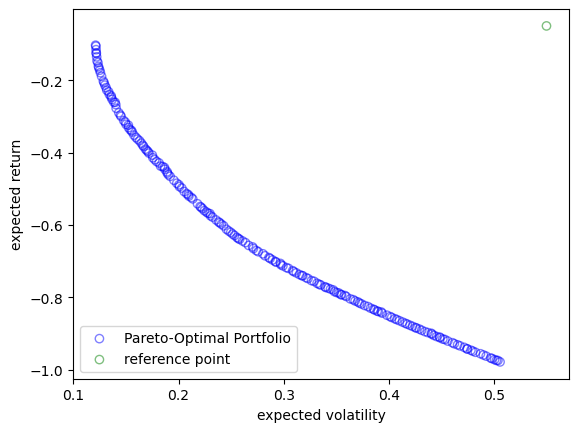

  Hypervolume@600: 0.285185

Run 5/10 - FloatRandom_SBX - 500 gens


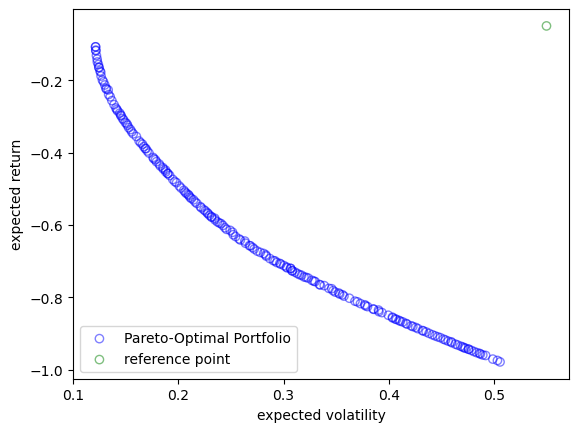

  Hypervolume@500: 0.285042
Run 5/10 - FloatRandom_SBX - 600 gens


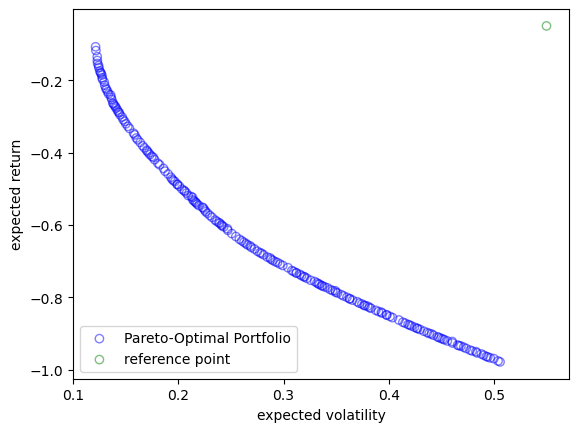

  Hypervolume@600: 0.285213

Run 5/10 - FloatRandom_TwoPt - 500 gens


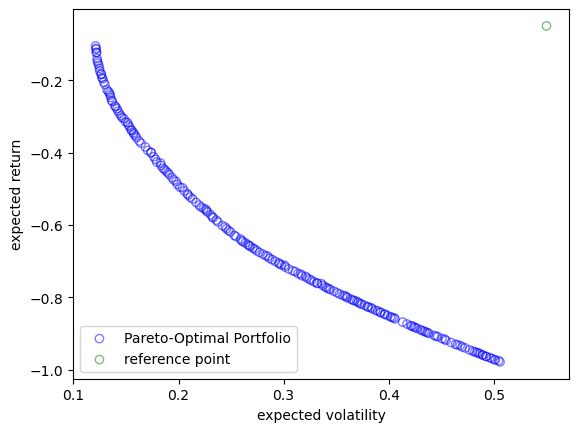

  Hypervolume@500: 0.284980
Run 5/10 - FloatRandom_TwoPt - 600 gens


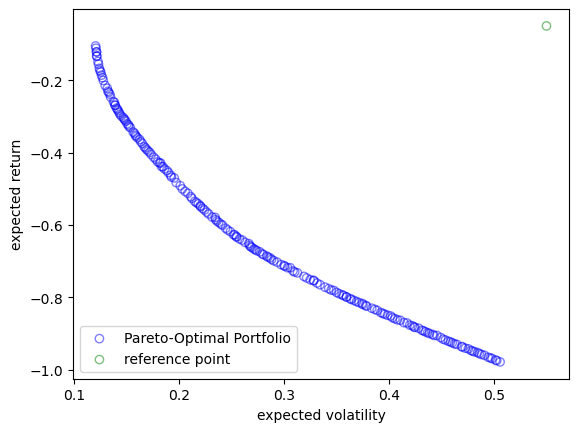

  Hypervolume@600: 0.285030

Run 5/10 - FloatRandom_Uniform - 500 gens


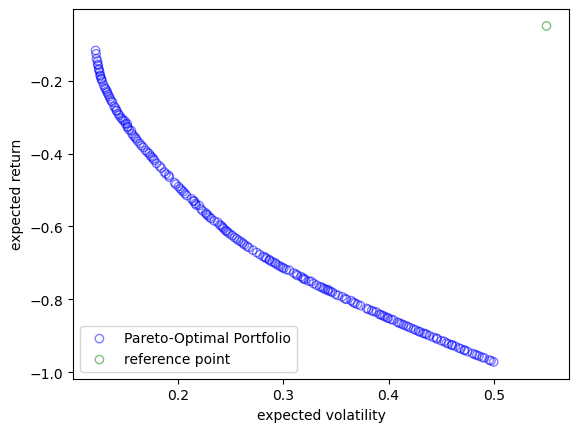

  Hypervolume@500: 0.284901
Run 5/10 - FloatRandom_Uniform - 600 gens


  Hypervolume@600: 0.285004

Run 5/10 - LHS_SBX - 500 gens


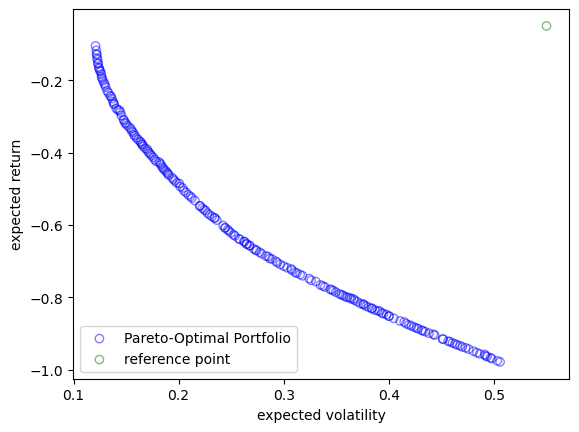

  Hypervolume@500: 0.285046
Run 5/10 - LHS_SBX - 600 gens


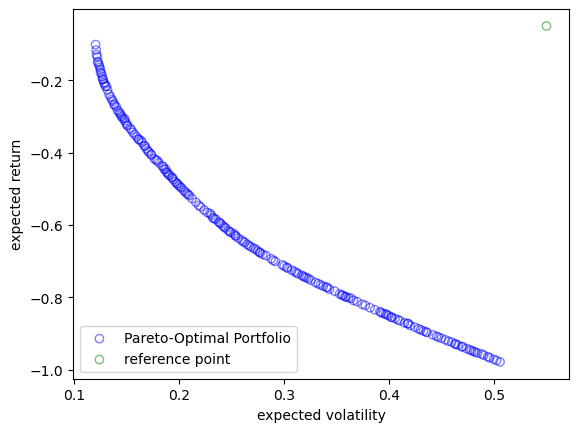

  Hypervolume@600: 0.285164

Run 5/10 - LHS_TwoPt - 500 gens


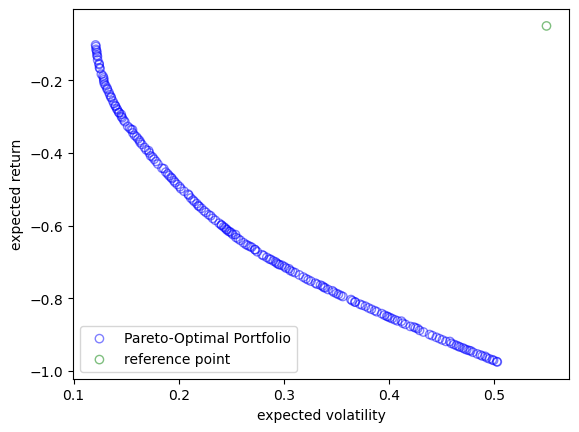

  Hypervolume@500: 0.284973
Run 5/10 - LHS_TwoPt - 600 gens


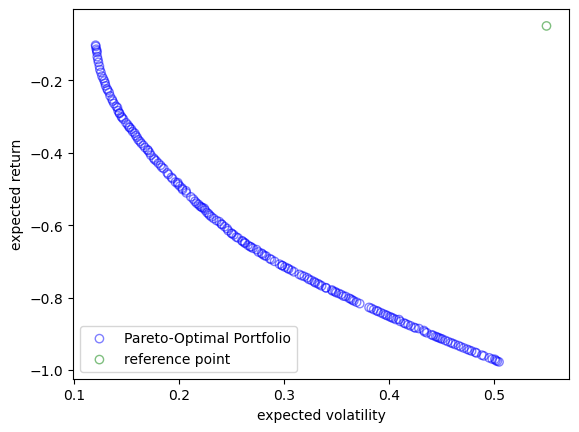

  Hypervolume@600: 0.285058

Run 5/10 - LHS_Uniform - 500 gens


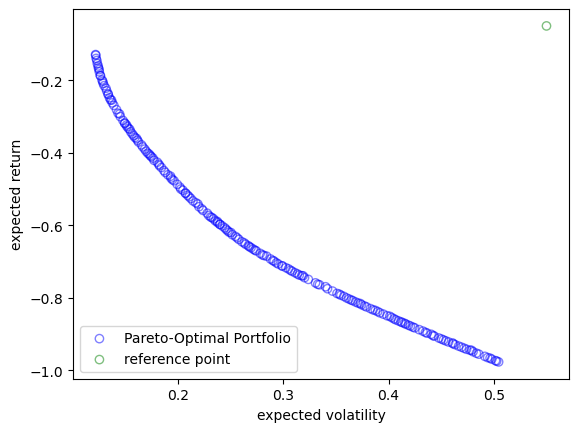

  Hypervolume@500: 0.285175
Run 5/10 - LHS_Uniform - 600 gens


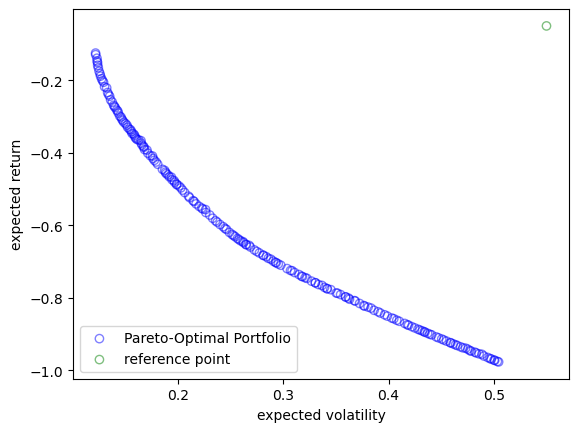

  Hypervolume@600: 0.285128

Run 6/10 - BinaryRandom_SBX - 500 gens


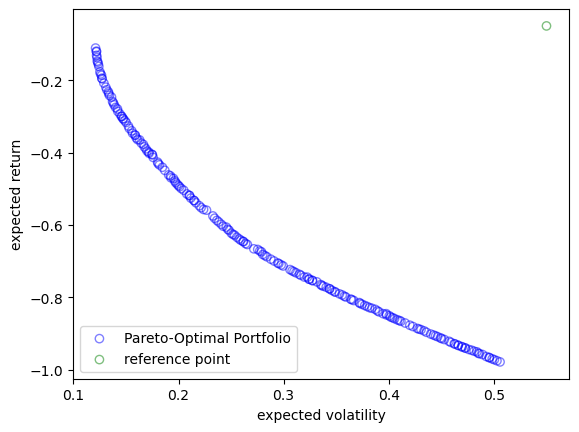

  Hypervolume@500: 0.285057
Run 6/10 - BinaryRandom_SBX - 600 gens


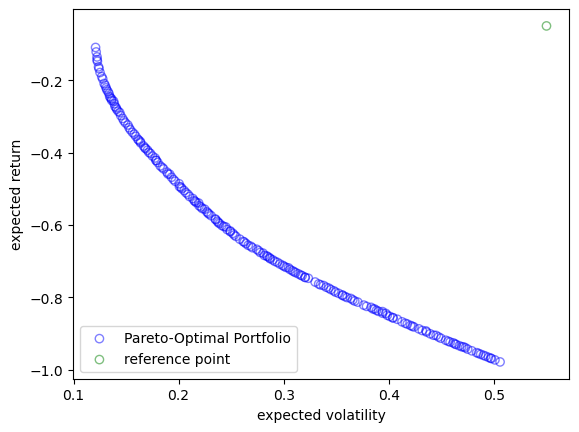

  Hypervolume@600: 0.285145

Run 6/10 - BinaryRandom_TwoPt - 500 gens


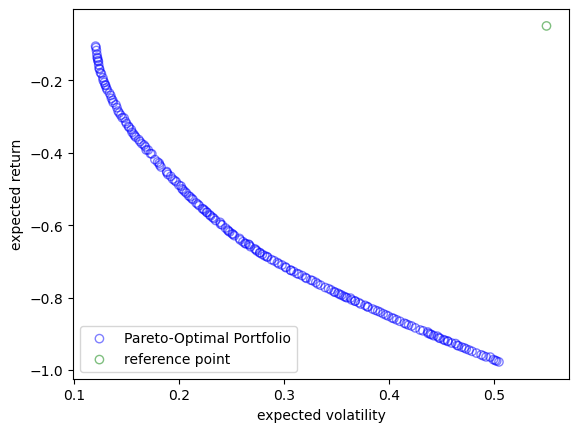

  Hypervolume@500: 0.285081
Run 6/10 - BinaryRandom_TwoPt - 600 gens


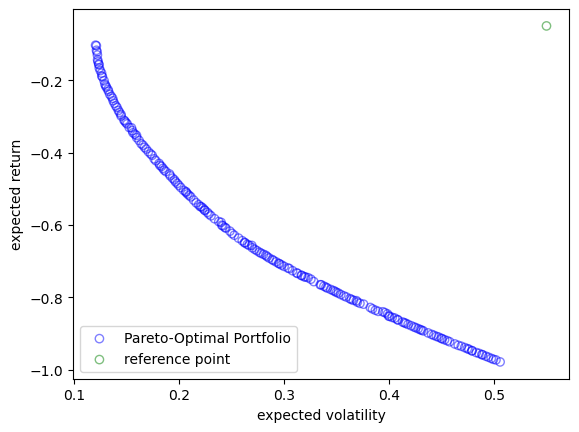

  Hypervolume@600: 0.285223

Run 6/10 - BinaryRandom_Uniform - 500 gens


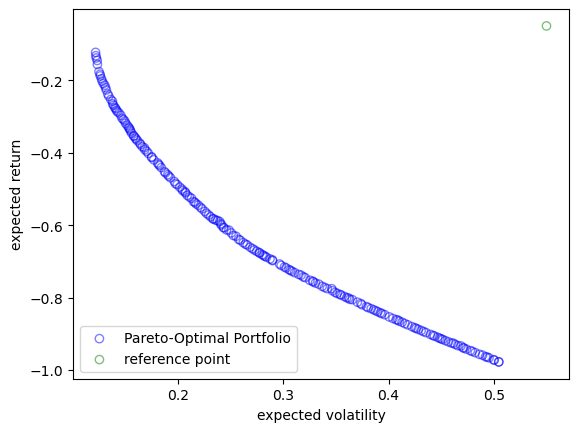

  Hypervolume@500: 0.285151
Run 6/10 - BinaryRandom_Uniform - 600 gens


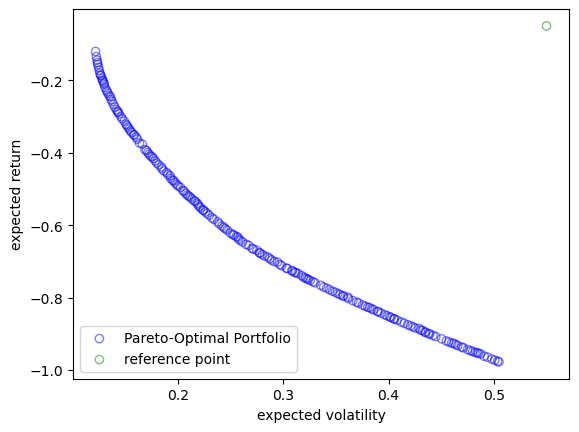

  Hypervolume@600: 0.285248

Run 6/10 - FloatRandom_SBX - 500 gens


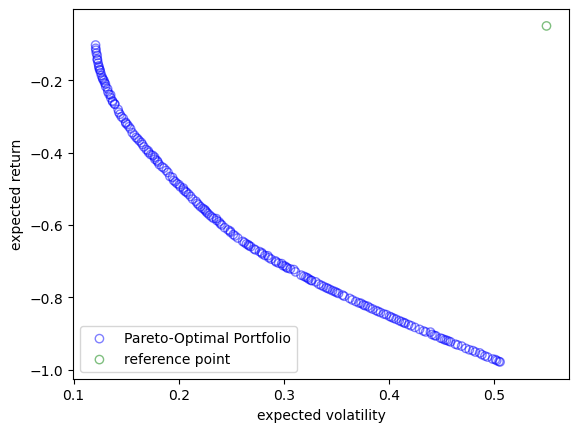

  Hypervolume@500: 0.285146
Run 6/10 - FloatRandom_SBX - 600 gens


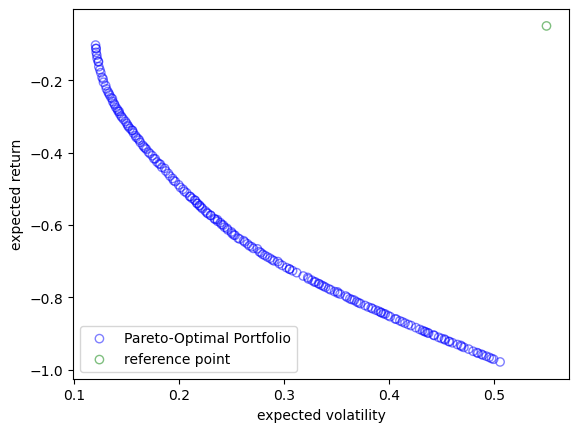

  Hypervolume@600: 0.285147

Run 6/10 - FloatRandom_TwoPt - 500 gens


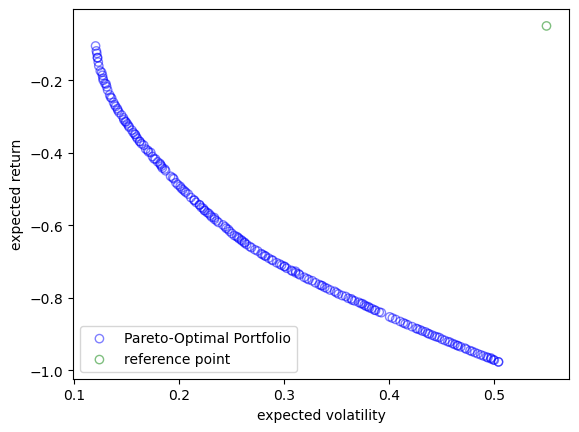

  Hypervolume@500: 0.285056
Run 6/10 - FloatRandom_TwoPt - 600 gens


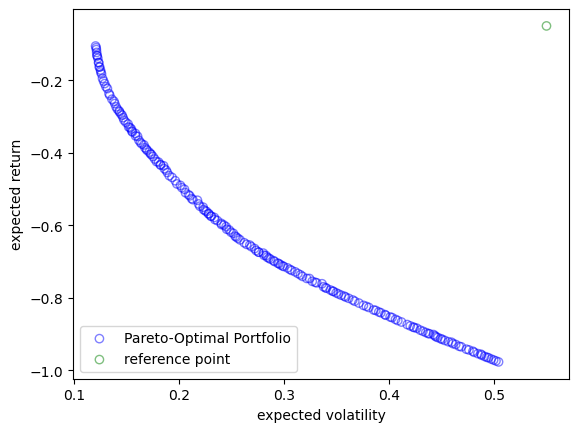

  Hypervolume@600: 0.284977

Run 6/10 - FloatRandom_Uniform - 500 gens


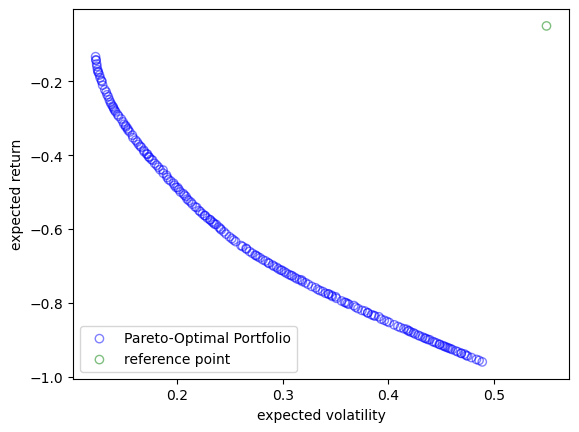

  Hypervolume@500: 0.284173
Run 6/10 - FloatRandom_Uniform - 600 gens


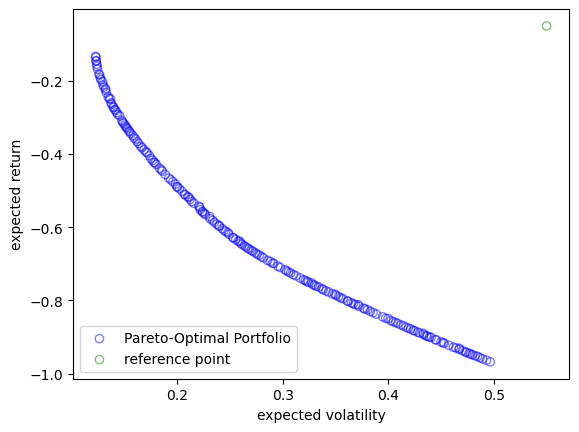

  Hypervolume@600: 0.284700

Run 6/10 - LHS_SBX - 500 gens


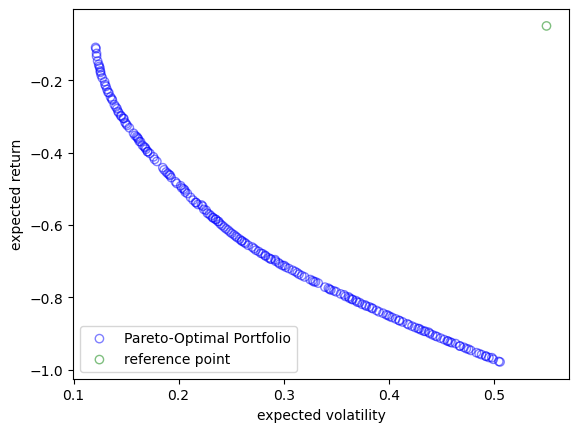

  Hypervolume@500: 0.285060
Run 6/10 - LHS_SBX - 600 gens


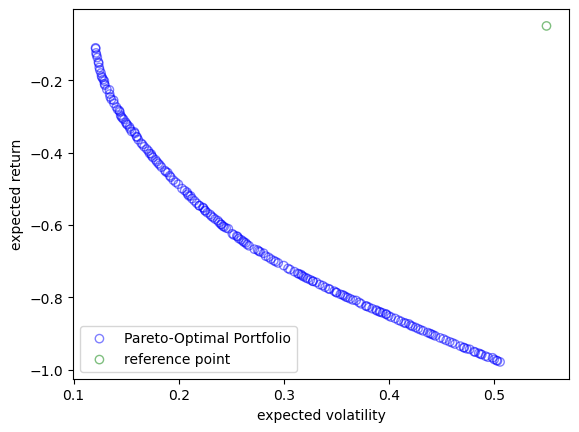

  Hypervolume@600: 0.285110

Run 6/10 - LHS_TwoPt - 500 gens


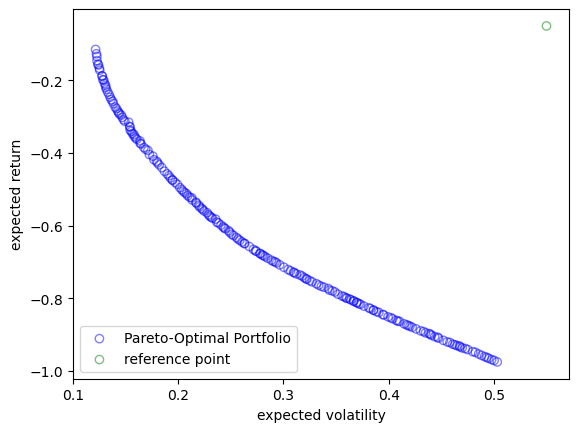

  Hypervolume@500: 0.284936
Run 6/10 - LHS_TwoPt - 600 gens


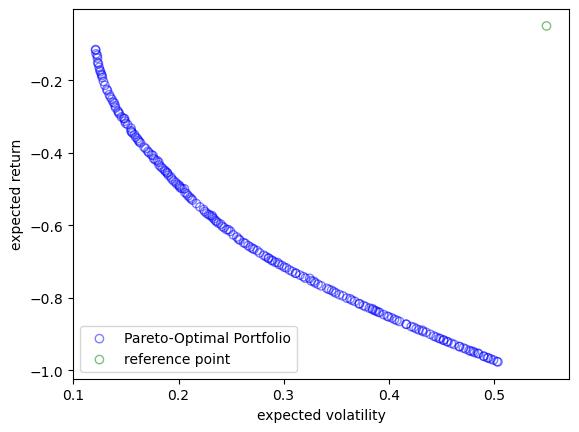

  Hypervolume@600: 0.285002

Run 6/10 - LHS_Uniform - 500 gens


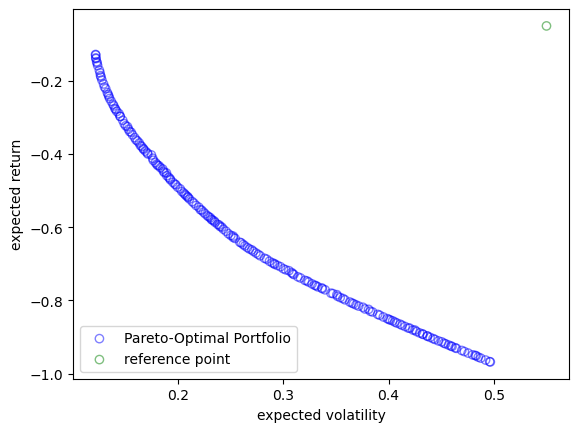

  Hypervolume@500: 0.284727
Run 6/10 - LHS_Uniform - 600 gens


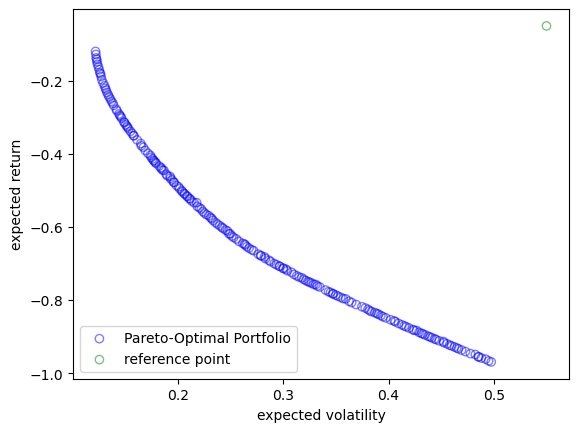

  Hypervolume@600: 0.284823

Run 7/10 - BinaryRandom_SBX - 500 gens


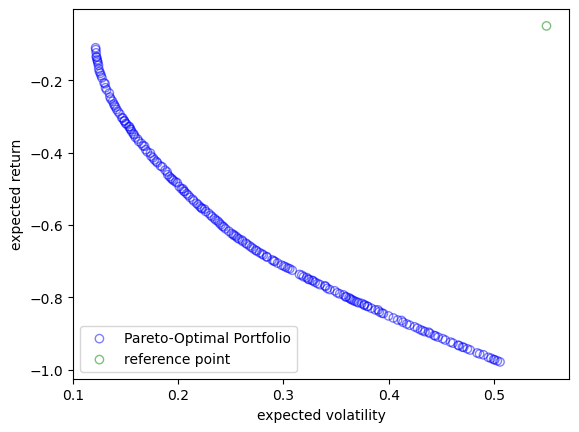

  Hypervolume@500: 0.285101
Run 7/10 - BinaryRandom_SBX - 600 gens


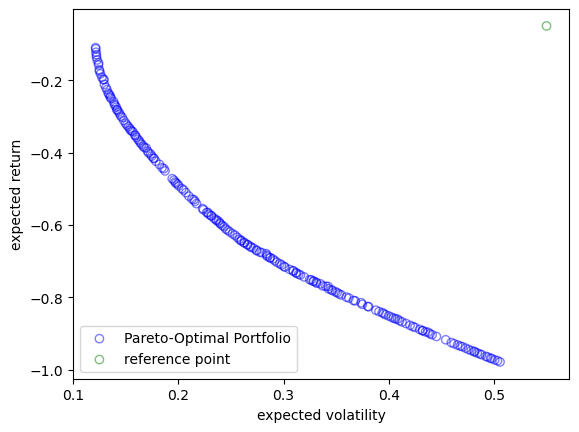

  Hypervolume@600: 0.284978

Run 7/10 - BinaryRandom_TwoPt - 500 gens


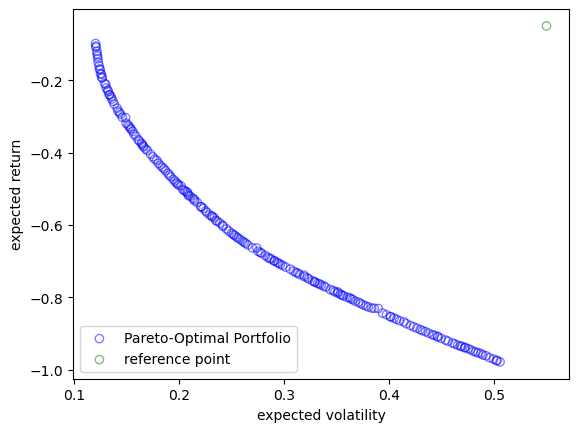

  Hypervolume@500: 0.285089
Run 7/10 - BinaryRandom_TwoPt - 600 gens


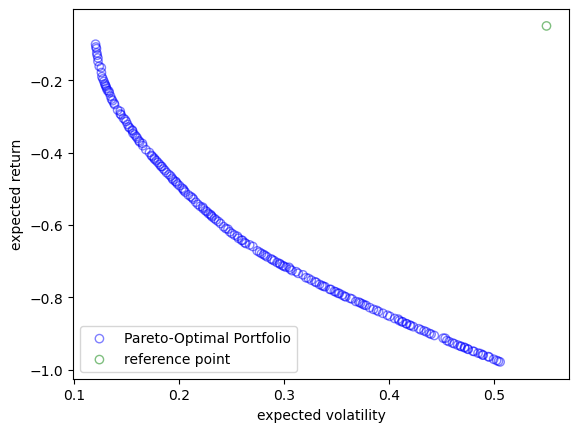

  Hypervolume@600: 0.285145

Run 7/10 - BinaryRandom_Uniform - 500 gens


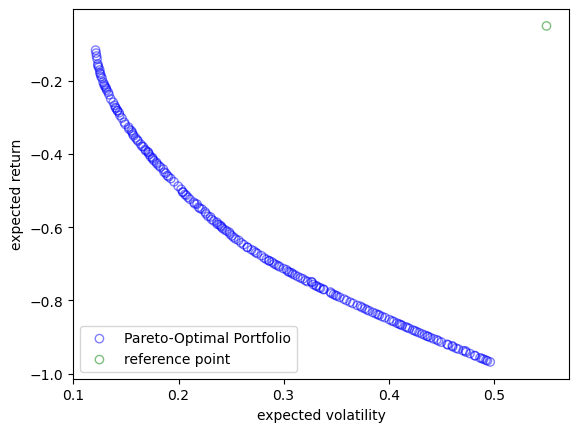

  Hypervolume@500: 0.284745
Run 7/10 - BinaryRandom_Uniform - 600 gens


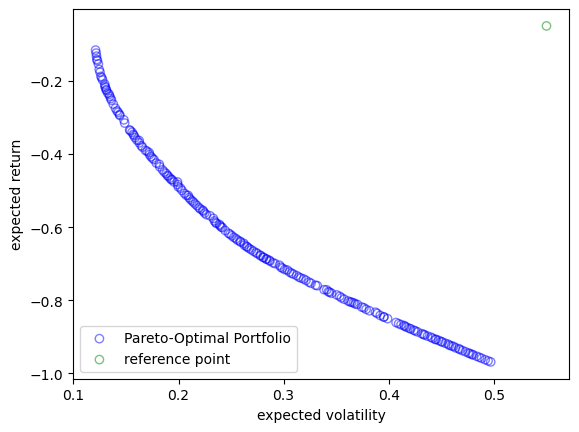

  Hypervolume@600: 0.284718

Run 7/10 - FloatRandom_SBX - 500 gens


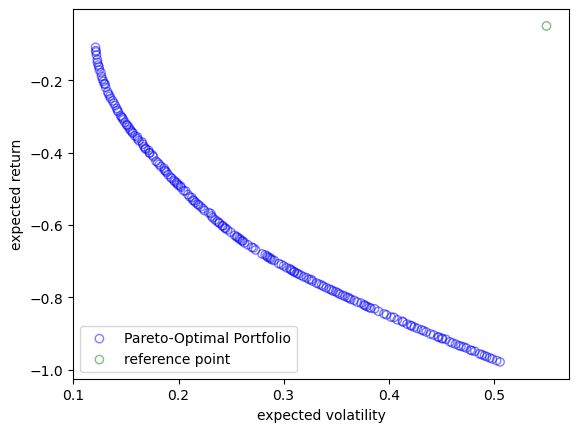

  Hypervolume@500: 0.285140
Run 7/10 - FloatRandom_SBX - 600 gens


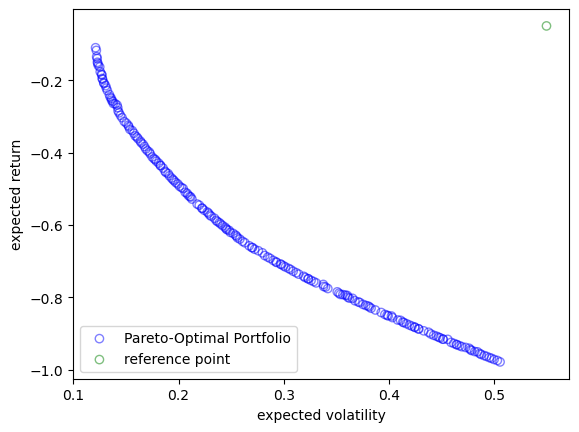

  Hypervolume@600: 0.285035

Run 7/10 - FloatRandom_TwoPt - 500 gens


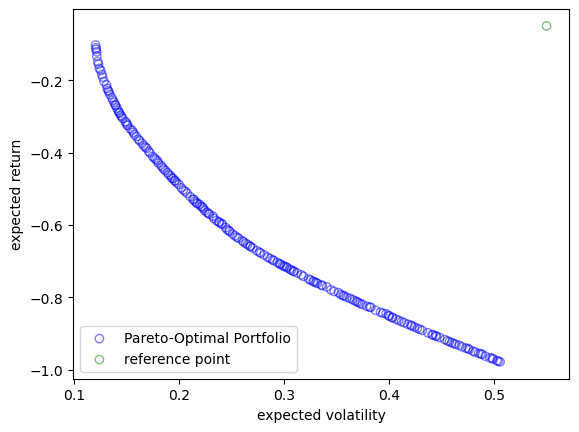

  Hypervolume@500: 0.285145
Run 7/10 - FloatRandom_TwoPt - 600 gens


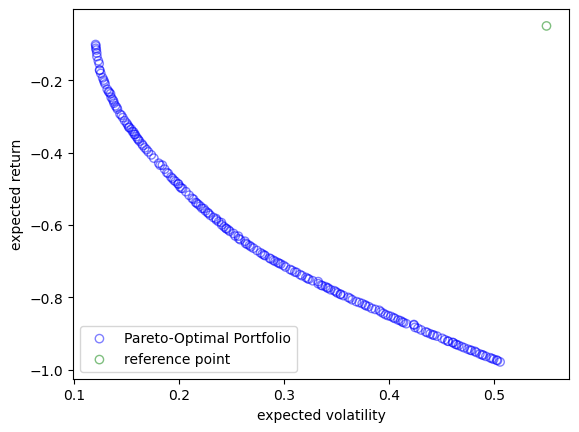

  Hypervolume@600: 0.285134

Run 7/10 - FloatRandom_Uniform - 500 gens


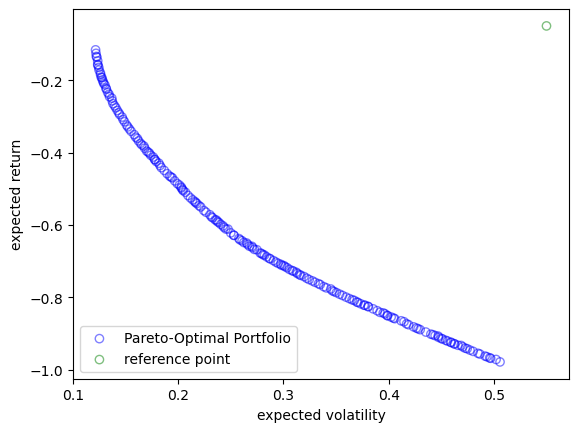

  Hypervolume@500: 0.285199
Run 7/10 - FloatRandom_Uniform - 600 gens


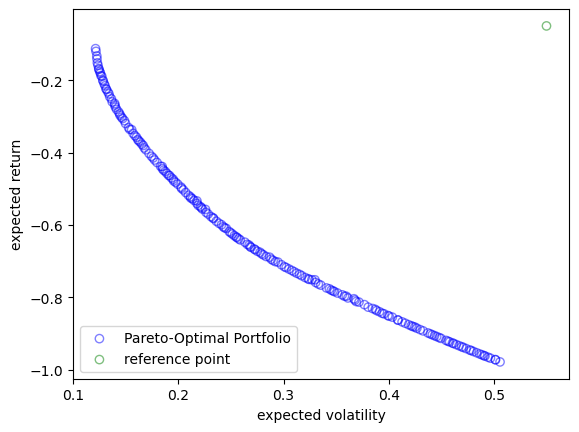

  Hypervolume@600: 0.285256

Run 7/10 - LHS_SBX - 500 gens


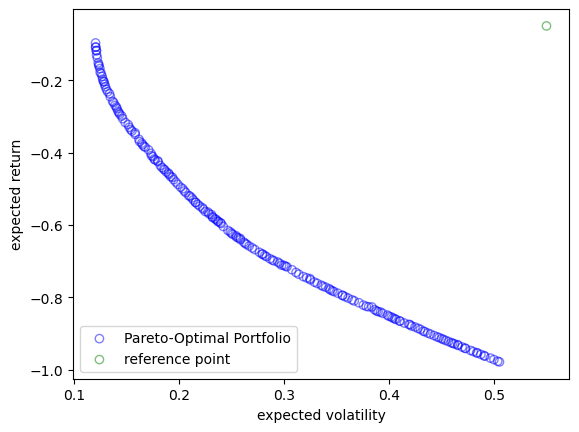

  Hypervolume@500: 0.285040
Run 7/10 - LHS_SBX - 600 gens


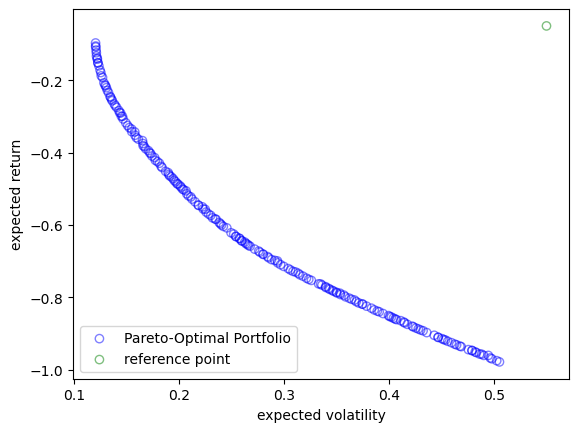

  Hypervolume@600: 0.284980

Run 7/10 - LHS_TwoPt - 500 gens


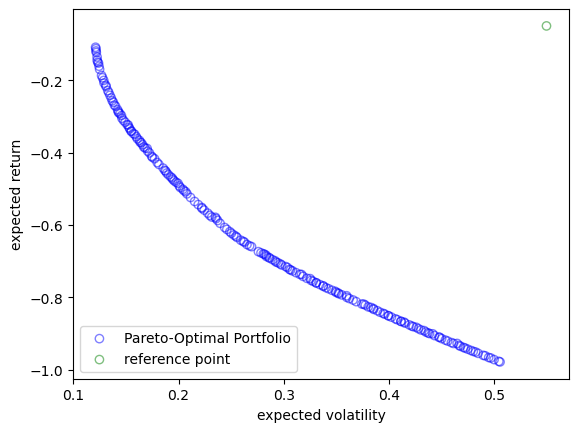

  Hypervolume@500: 0.285127
Run 7/10 - LHS_TwoPt - 600 gens


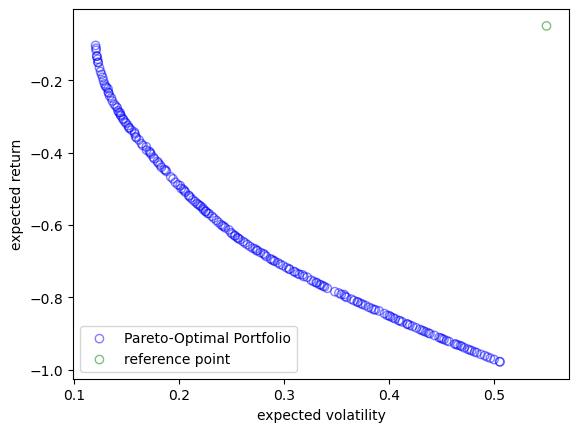

  Hypervolume@600: 0.285195

Run 7/10 - LHS_Uniform - 500 gens


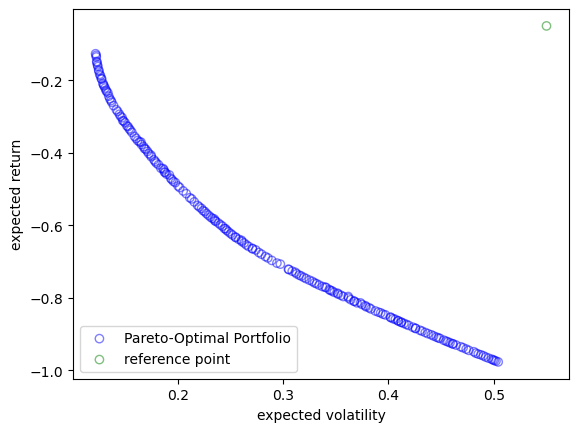

  Hypervolume@500: 0.285060
Run 7/10 - LHS_Uniform - 600 gens


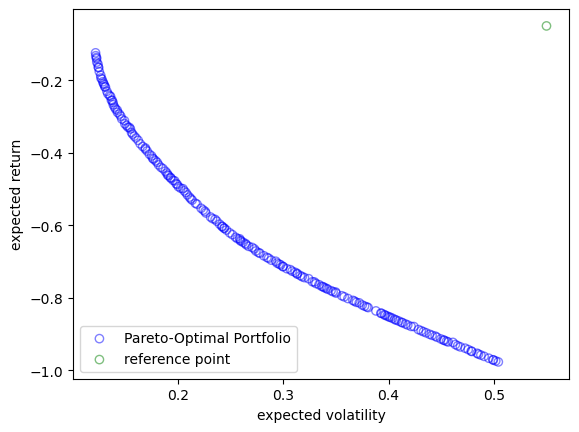

  Hypervolume@600: 0.285025

Run 8/10 - BinaryRandom_SBX - 500 gens


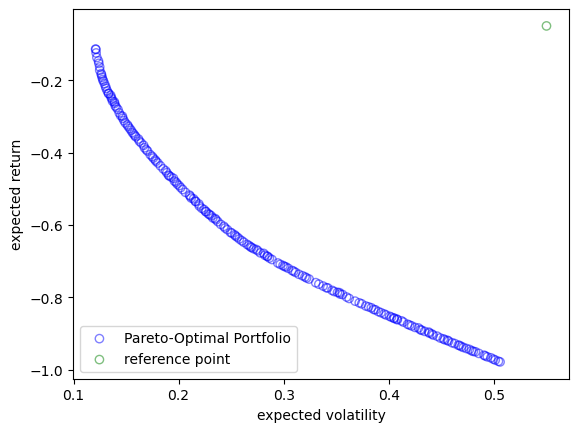

  Hypervolume@500: 0.285189
Run 8/10 - BinaryRandom_SBX - 600 gens


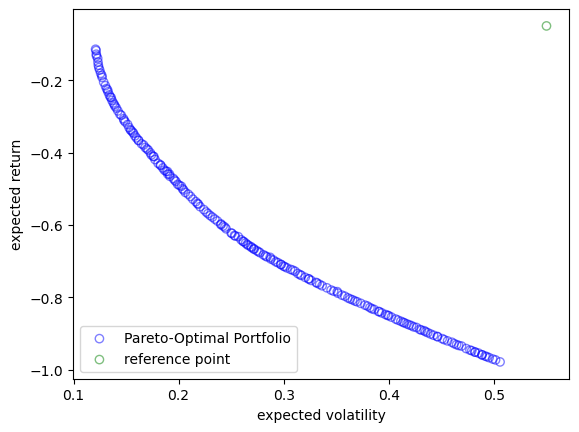

  Hypervolume@600: 0.285188

Run 8/10 - BinaryRandom_TwoPt - 500 gens


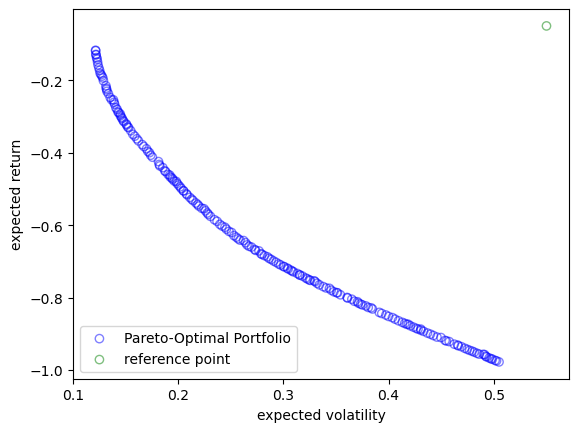

  Hypervolume@500: 0.285027
Run 8/10 - BinaryRandom_TwoPt - 600 gens


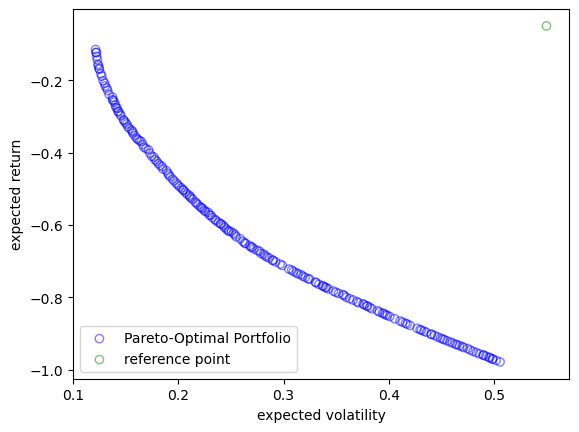

  Hypervolume@600: 0.285105

Run 8/10 - BinaryRandom_Uniform - 500 gens


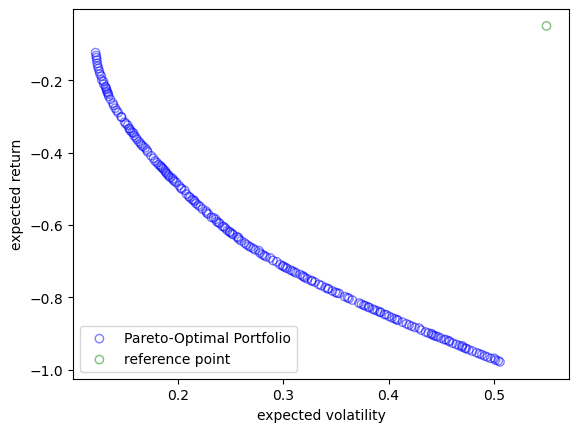

  Hypervolume@500: 0.285128
Run 8/10 - BinaryRandom_Uniform - 600 gens


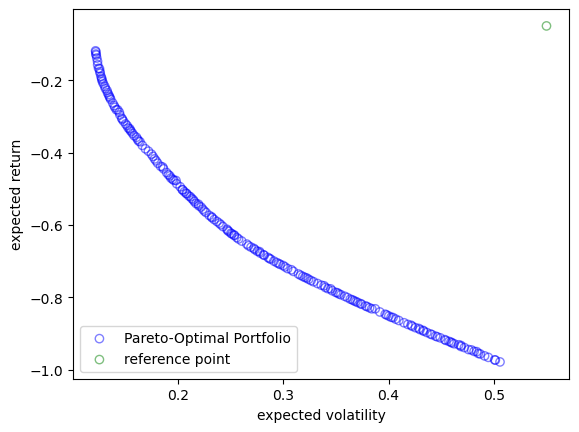

  Hypervolume@600: 0.285188

Run 8/10 - FloatRandom_SBX - 500 gens


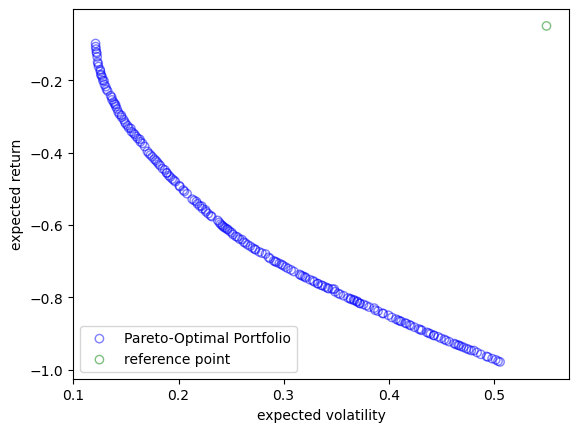

  Hypervolume@500: 0.285043
Run 8/10 - FloatRandom_SBX - 600 gens


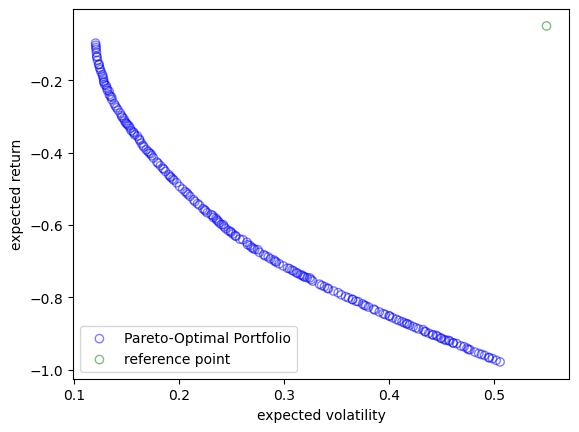

  Hypervolume@600: 0.285106

Run 8/10 - FloatRandom_TwoPt - 500 gens


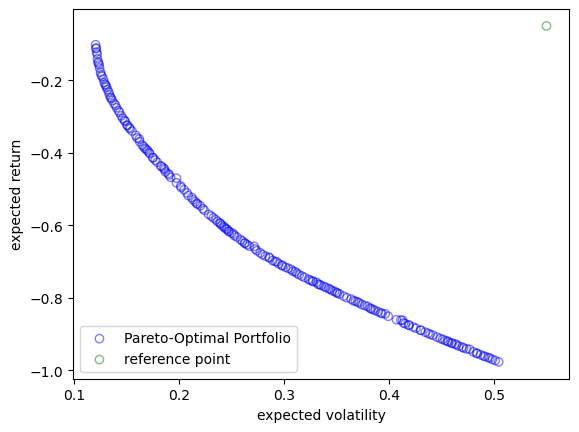

  Hypervolume@500: 0.285040
Run 8/10 - FloatRandom_TwoPt - 600 gens


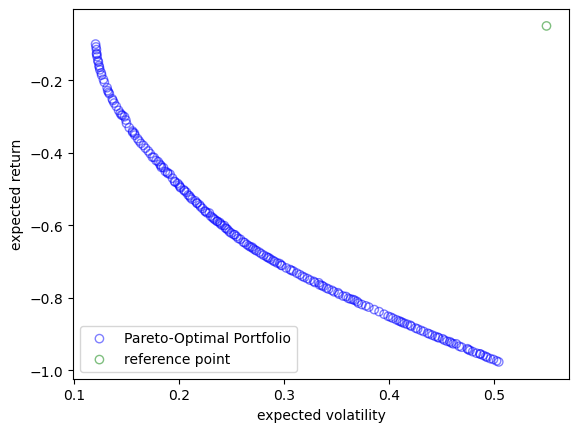

  Hypervolume@600: 0.285034

Run 8/10 - FloatRandom_Uniform - 500 gens


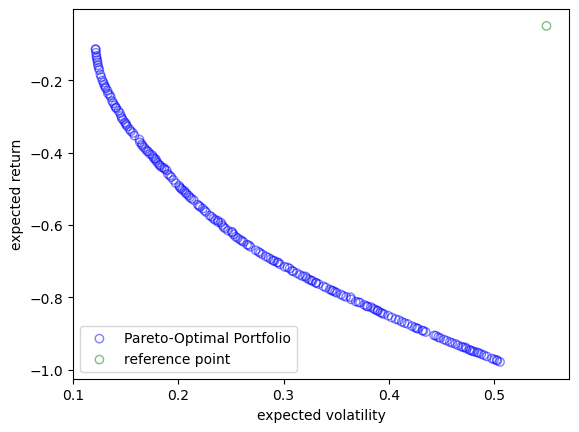

  Hypervolume@500: 0.285178
Run 8/10 - FloatRandom_Uniform - 600 gens


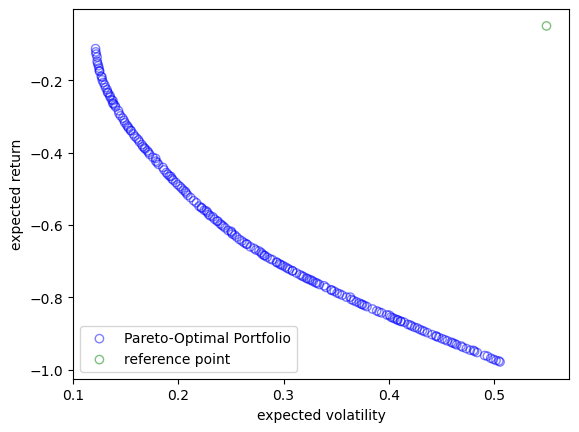

  Hypervolume@600: 0.285214

Run 8/10 - LHS_SBX - 500 gens


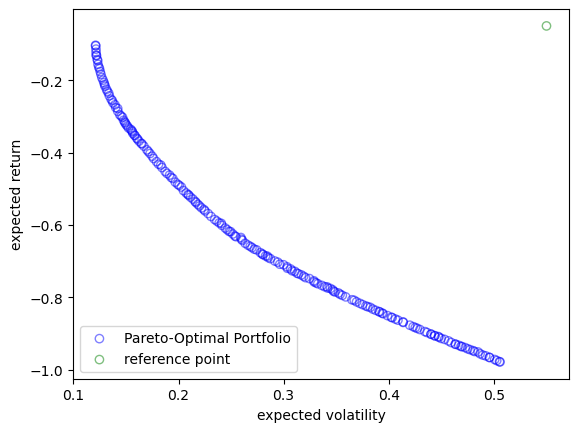

  Hypervolume@500: 0.285161
Run 8/10 - LHS_SBX - 600 gens


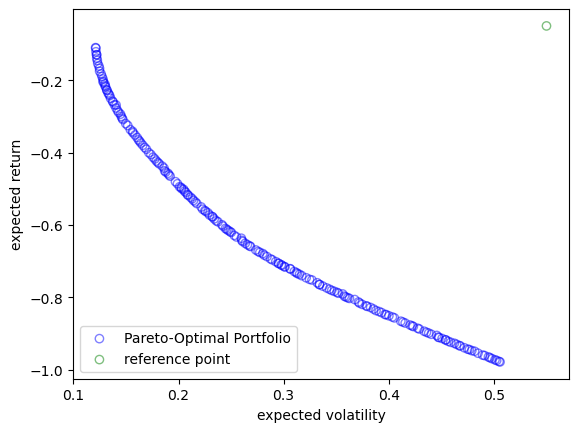

  Hypervolume@600: 0.285077

Run 8/10 - LHS_TwoPt - 500 gens


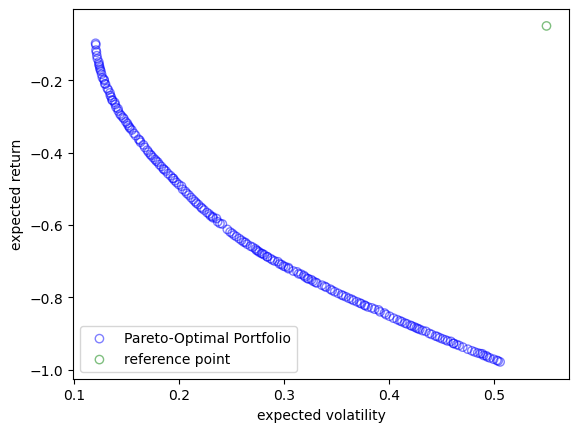

  Hypervolume@500: 0.285157
Run 8/10 - LHS_TwoPt - 600 gens


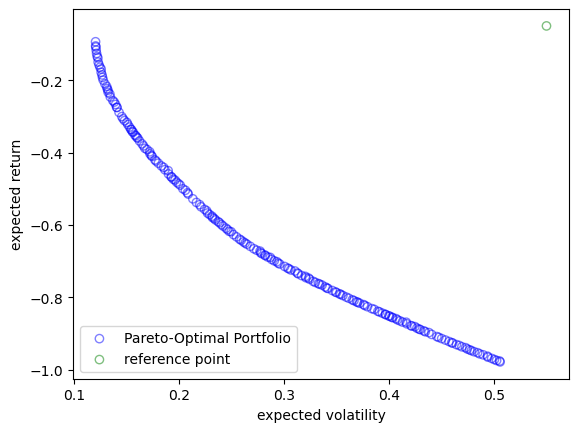

  Hypervolume@600: 0.285169

Run 8/10 - LHS_Uniform - 500 gens


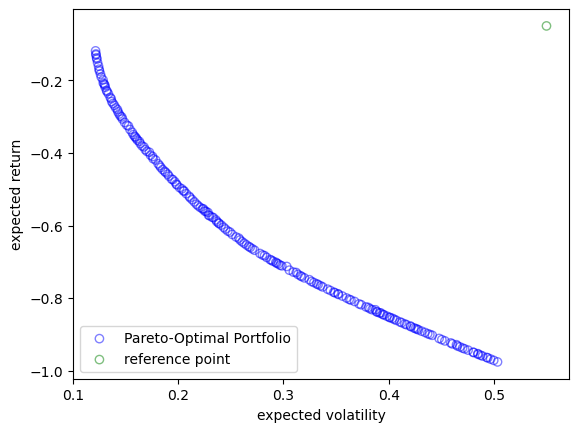

  Hypervolume@500: 0.285100
Run 8/10 - LHS_Uniform - 600 gens


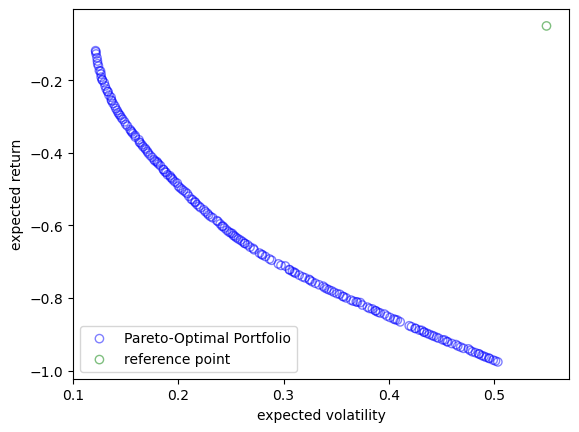

  Hypervolume@600: 0.285084

Run 9/10 - BinaryRandom_SBX - 500 gens


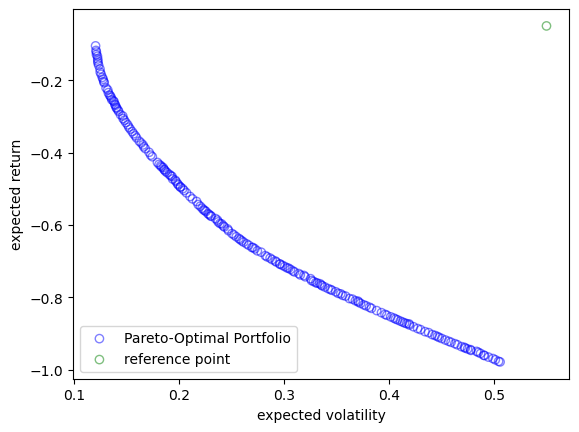

  Hypervolume@500: 0.285172
Run 9/10 - BinaryRandom_SBX - 600 gens


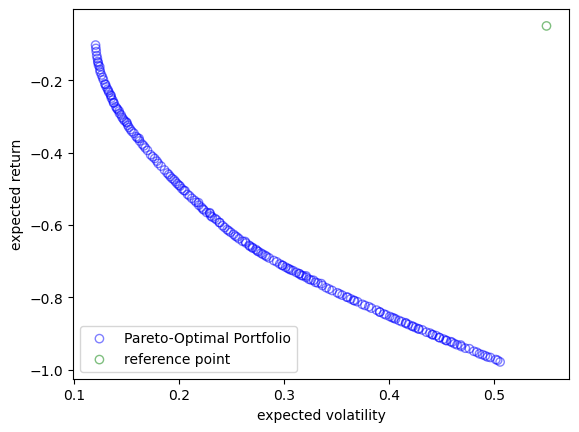

  Hypervolume@600: 0.285255

Run 9/10 - BinaryRandom_TwoPt - 500 gens


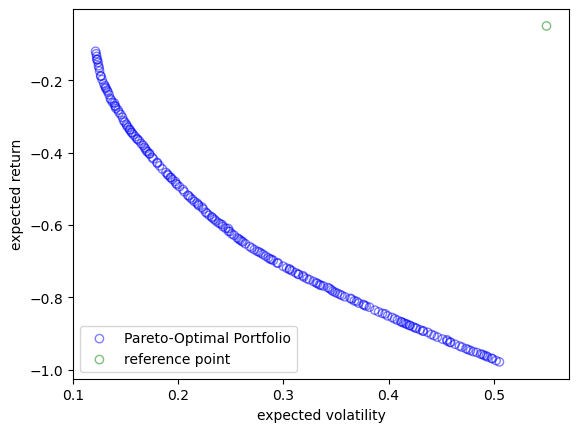

  Hypervolume@500: 0.285130
Run 9/10 - BinaryRandom_TwoPt - 600 gens


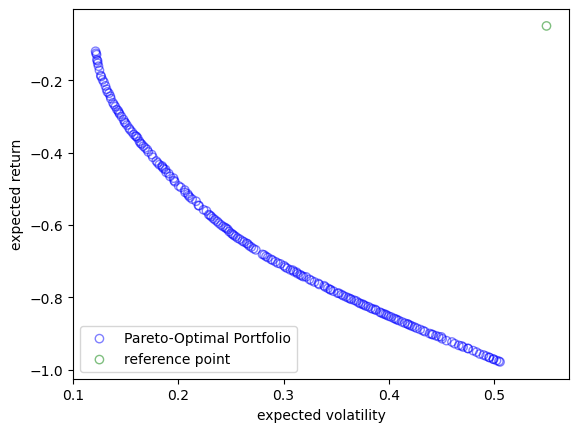

  Hypervolume@600: 0.285118

Run 9/10 - BinaryRandom_Uniform - 500 gens


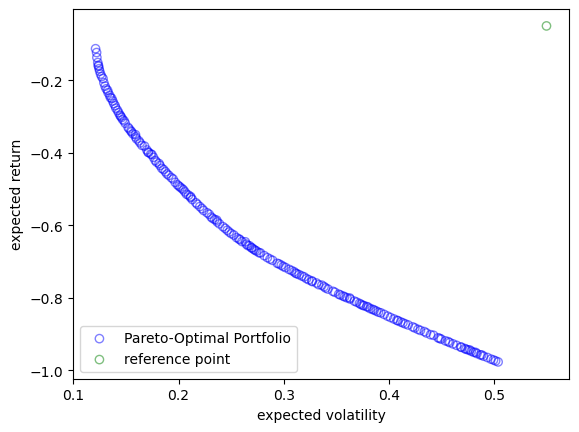

  Hypervolume@500: 0.285214
Run 9/10 - BinaryRandom_Uniform - 600 gens


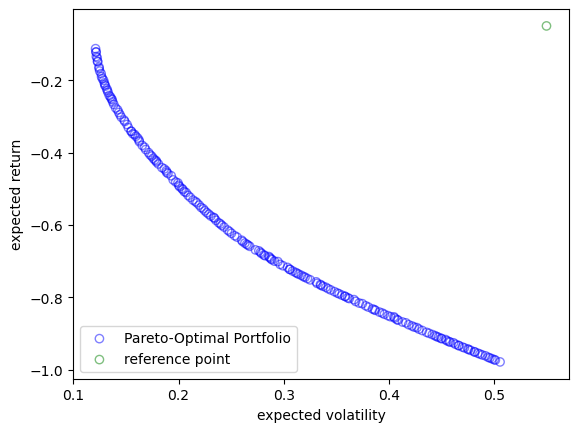

  Hypervolume@600: 0.285303

Run 9/10 - FloatRandom_SBX - 500 gens


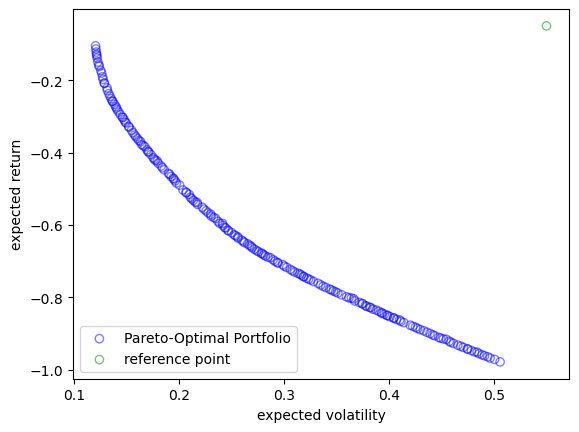

  Hypervolume@500: 0.285159
Run 9/10 - FloatRandom_SBX - 600 gens


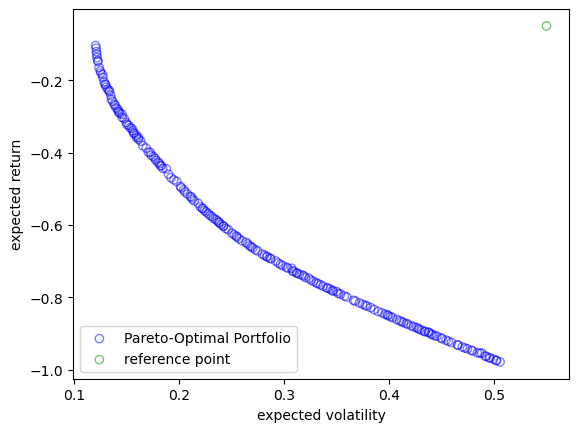

  Hypervolume@600: 0.285096

Run 9/10 - FloatRandom_TwoPt - 500 gens


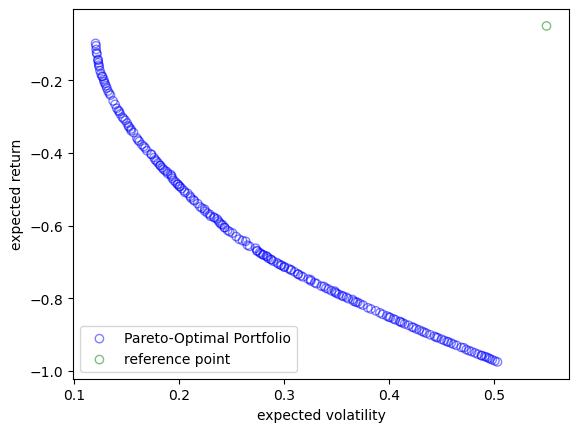

  Hypervolume@500: 0.284884
Run 9/10 - FloatRandom_TwoPt - 600 gens


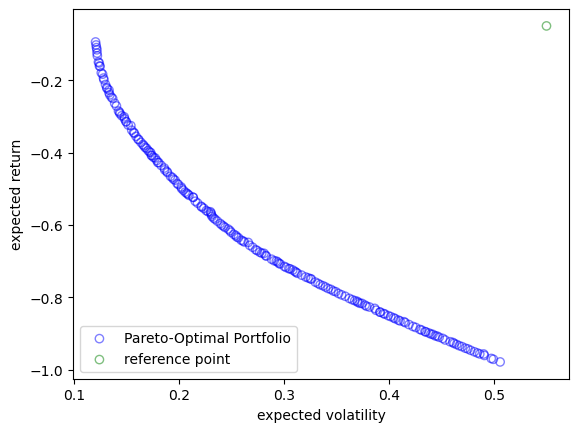

  Hypervolume@600: 0.285024

Run 9/10 - FloatRandom_Uniform - 500 gens


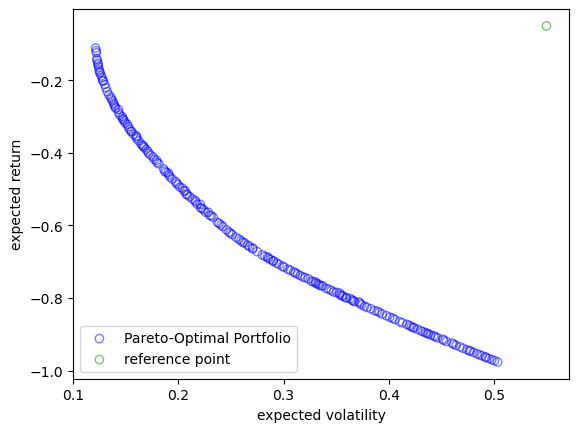

  Hypervolume@500: 0.285053
Run 9/10 - FloatRandom_Uniform - 600 gens


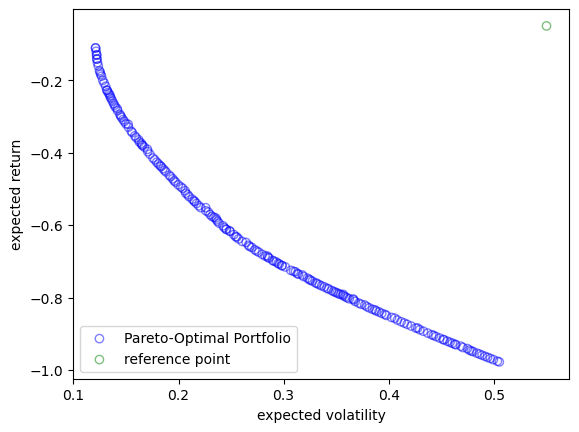

  Hypervolume@600: 0.285180

Run 9/10 - LHS_SBX - 500 gens


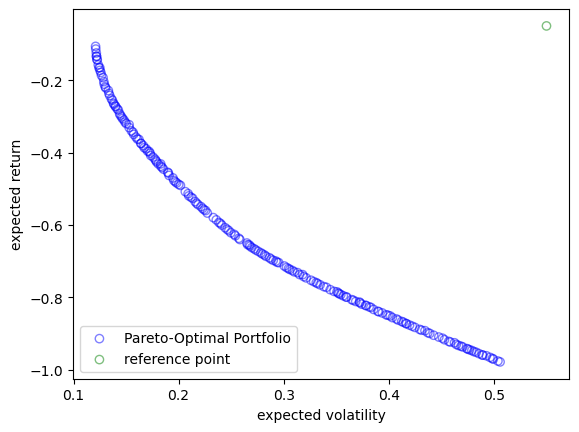

  Hypervolume@500: 0.285106
Run 9/10 - LHS_SBX - 600 gens


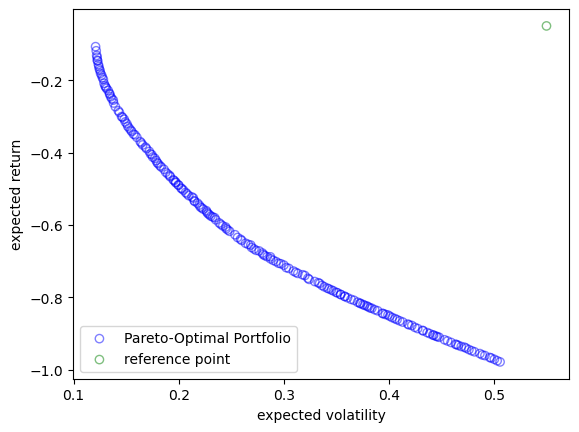

  Hypervolume@600: 0.285126

Run 9/10 - LHS_TwoPt - 500 gens


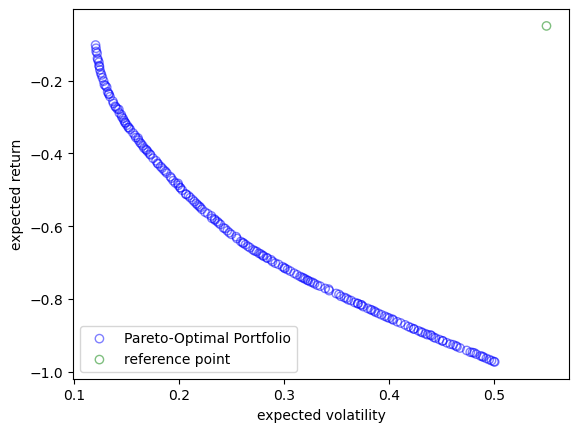

  Hypervolume@500: 0.284808
Run 9/10 - LHS_TwoPt - 600 gens


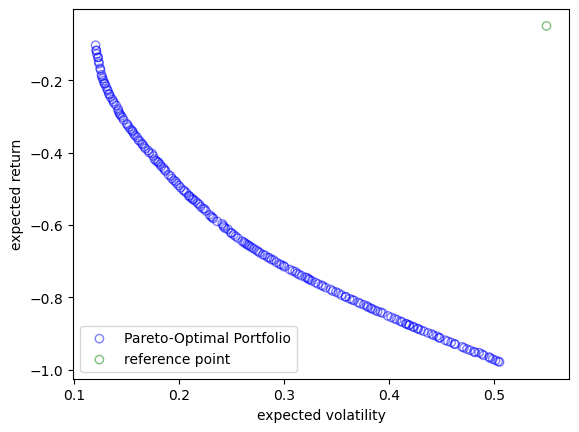

  Hypervolume@600: 0.285113

Run 9/10 - LHS_Uniform - 500 gens


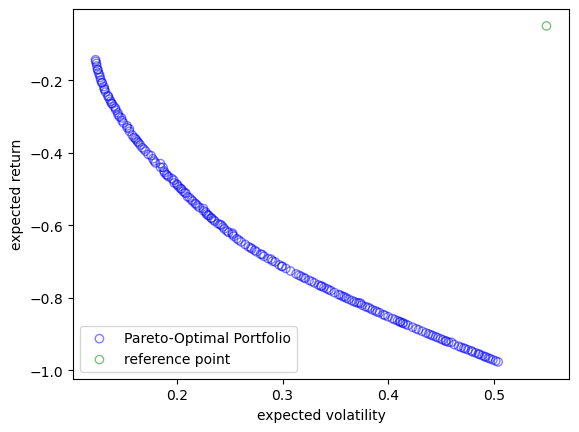

  Hypervolume@500: 0.285074
Run 9/10 - LHS_Uniform - 600 gens


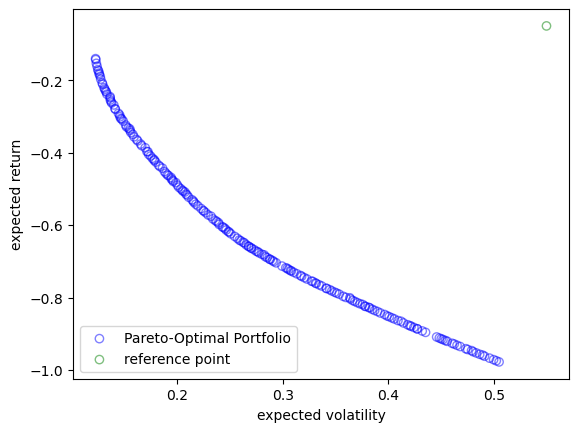

  Hypervolume@600: 0.285113

Run 10/10 - BinaryRandom_SBX - 500 gens


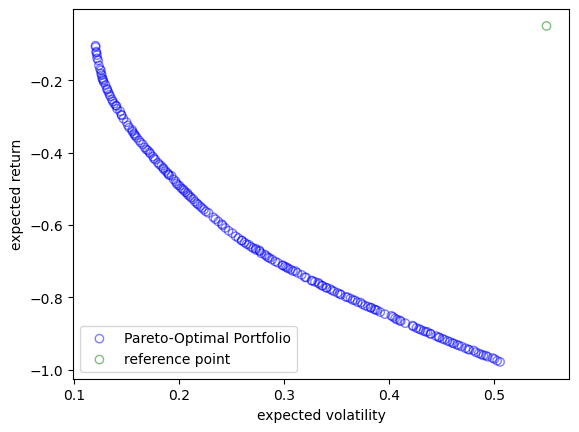

  Hypervolume@500: 0.285152
Run 10/10 - BinaryRandom_SBX - 600 gens


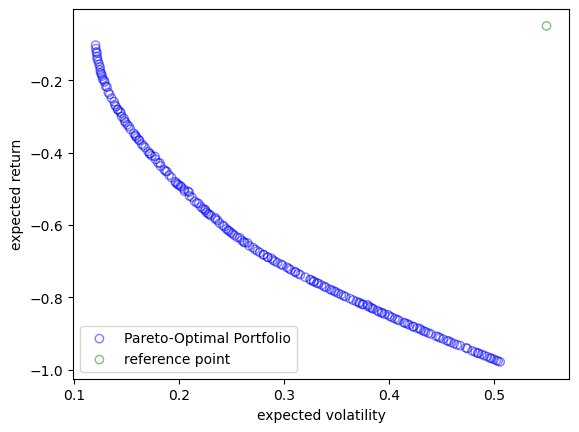

  Hypervolume@600: 0.285208

Run 10/10 - BinaryRandom_TwoPt - 500 gens


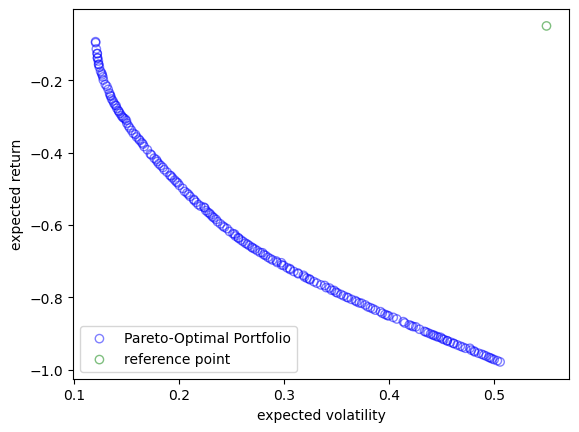

  Hypervolume@500: 0.285120
Run 10/10 - BinaryRandom_TwoPt - 600 gens


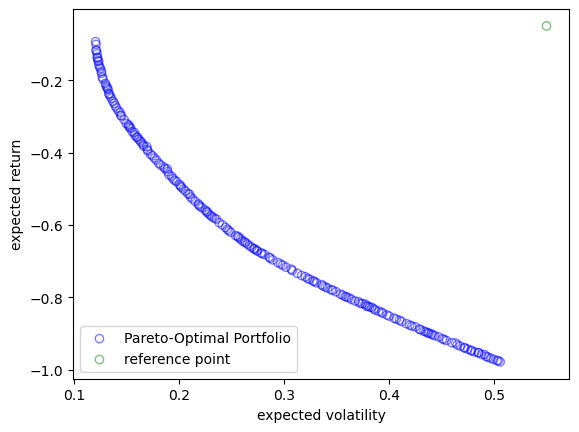

  Hypervolume@600: 0.285110

Run 10/10 - BinaryRandom_Uniform - 500 gens


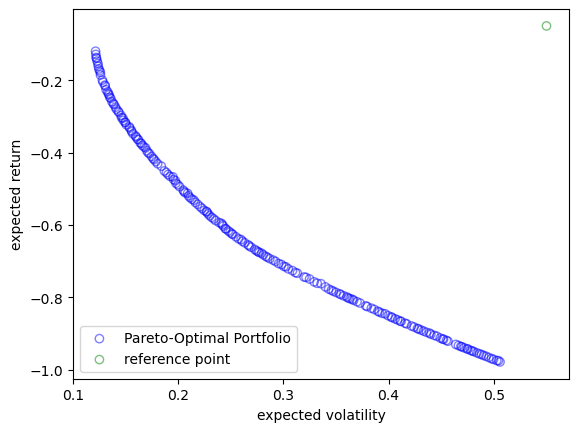

  Hypervolume@500: 0.285212
Run 10/10 - BinaryRandom_Uniform - 600 gens


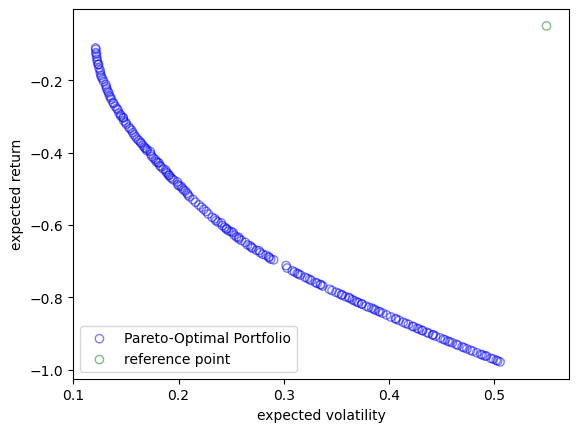

  Hypervolume@600: 0.285140

Run 10/10 - FloatRandom_SBX - 500 gens


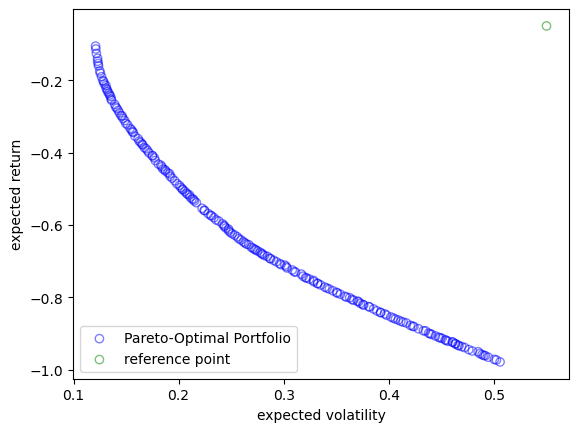

  Hypervolume@500: 0.285079
Run 10/10 - FloatRandom_SBX - 600 gens


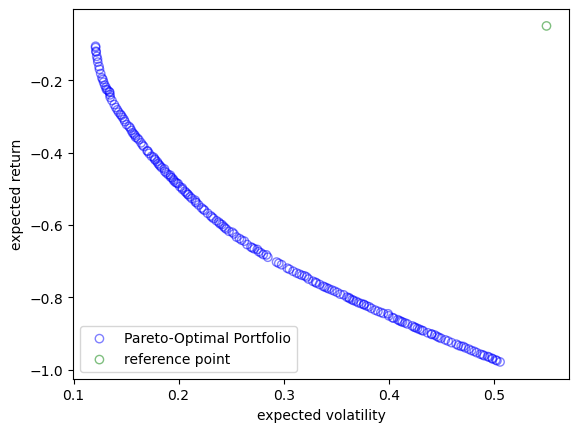

  Hypervolume@600: 0.285209

Run 10/10 - FloatRandom_TwoPt - 500 gens


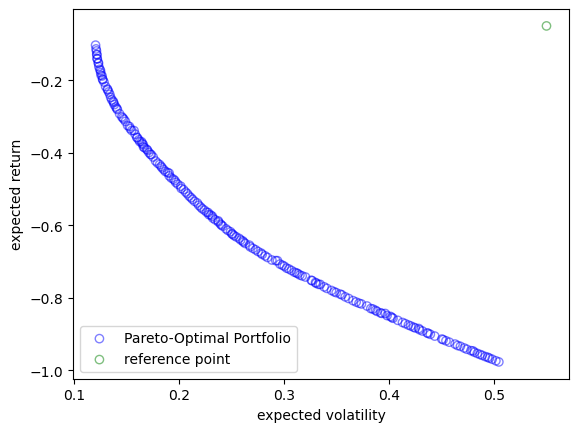

  Hypervolume@500: 0.285072
Run 10/10 - FloatRandom_TwoPt - 600 gens


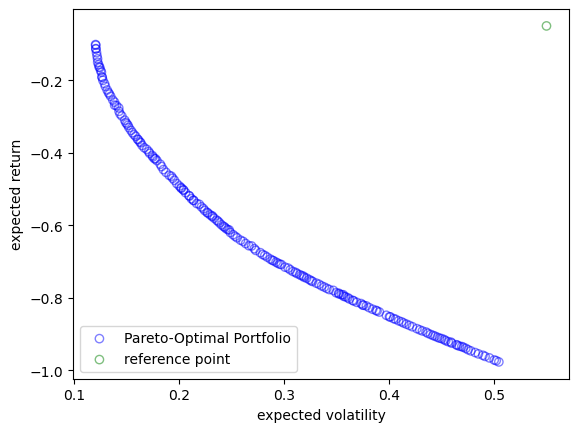

  Hypervolume@600: 0.285096

Run 10/10 - FloatRandom_Uniform - 500 gens


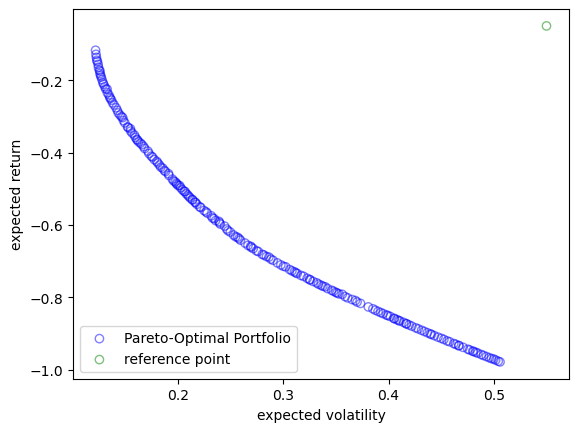

  Hypervolume@500: 0.285246
Run 10/10 - FloatRandom_Uniform - 600 gens


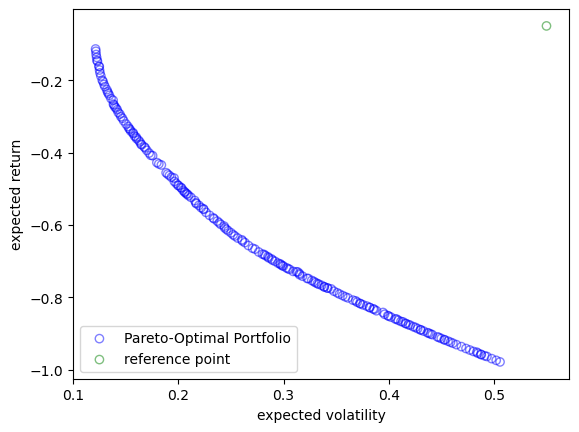

  Hypervolume@600: 0.285175

Run 10/10 - LHS_SBX - 500 gens


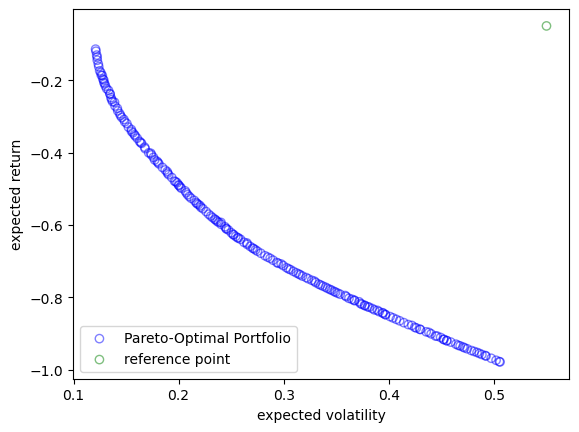

  Hypervolume@500: 0.285168
Run 10/10 - LHS_SBX - 600 gens


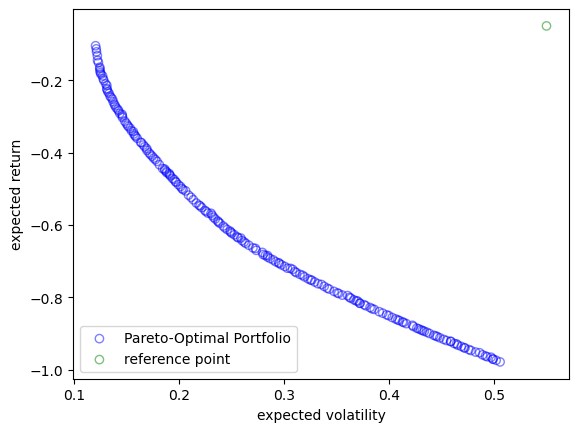

  Hypervolume@600: 0.285126

Run 10/10 - LHS_TwoPt - 500 gens


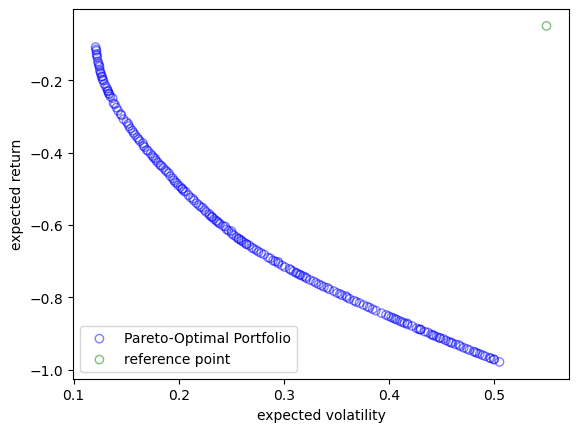

  Hypervolume@500: 0.285076
Run 10/10 - LHS_TwoPt - 600 gens


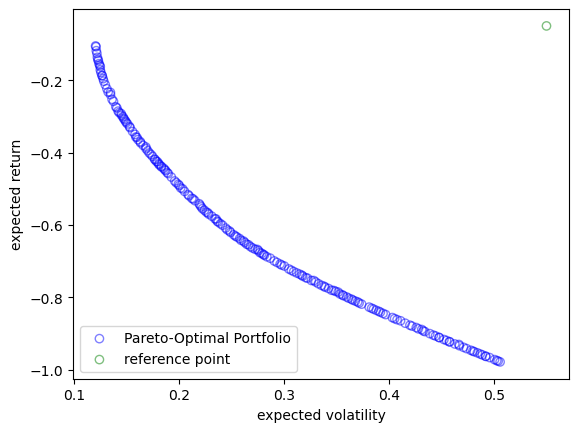

  Hypervolume@600: 0.285099

Run 10/10 - LHS_Uniform - 500 gens


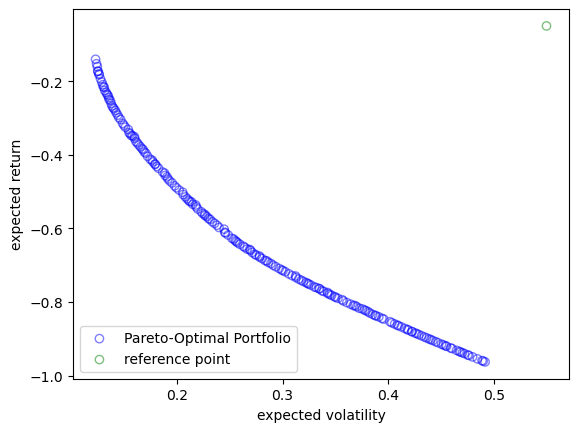

  Hypervolume@500: 0.284395
Run 10/10 - LHS_Uniform - 600 gens


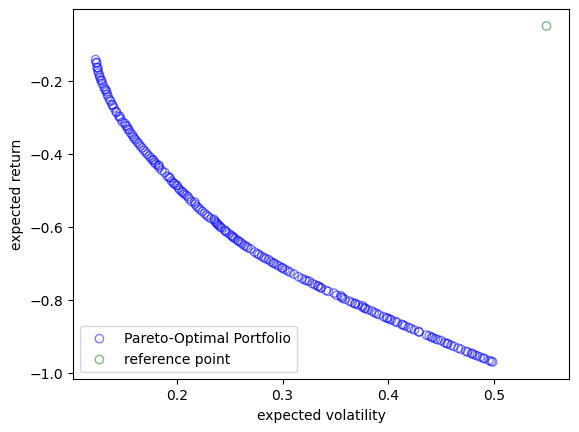

  Hypervolume@600: 0.284820

BinaryRandom_SBX: 500 gens -> mean 0.285138, std 0.000041;               600 gens -> mean 0.285147, std 0.000070
BinaryRandom_TwoPt: 500 gens -> mean 0.285077, std 0.000046;               600 gens -> mean 0.285125, std 0.000041
BinaryRandom_Uniform: 500 gens -> mean 0.284698, std 0.001197;               600 gens -> mean 0.284985, std 0.000403
FloatRandom_SBX: 500 gens -> mean 0.285107, std 0.000052;               600 gens -> mean 0.285128, std 0.000058
FloatRandom_TwoPt: 500 gens -> mean 0.285047, std 0.000076;               600 gens -> mean 0.285066, std 0.000055
FloatRandom_Uniform: 500 gens -> mean 0.284939, std 0.000329;               600 gens -> mean 0.285085, std 0.000227
LHS_SBX: 500 gens -> mean 0.285108, std 0.000051;               600 gens -> mean 0.285115, std 0.000053
LHS_TwoPt: 500 gens -> mean 0.285029, std 0.000101;               600 gens -> mean 0.285105, std 0.000066
LHS_Uniform: 500 gens -> mean 0.284949, std 0.000308;               600 ge

In [32]:
# Number of independent runs
test_time = 10
# Prepare storage for HV results
test_results = {conf['name']: {'500': [], '600': []} for conf in configurations}

for run_idx in range(test_time):
    # Assuming these functions are defined elsewhere:    
    problem = PortfolioProblem(mu, cov)    

    for config in configurations:
        # Build the NSGA2 algorithm with chosen operators
        algorithm = NSGA2(
            pop_size=200,
            sampling=config['sampling'],
            crossover=config['crossover'],
            repair=PortfolioRepair()
        )

        # 500 generations
        print(f"Run {run_idx+1}/{test_time} - {config['name']} - 500 gens")
        res_500 = minimize(
            problem,
            algorithm,
            termination=('n_gen', 500),
            seed=run_idx,
            verbose=False
        )

        X, F, sharpe = res_500.opt.get("X", "F", "sharpe")
        # F = F * [1, -1]  # Adjust for minimization/maximization
    
        hv_500 = calculate_HV(F)
        test_results[config['name']]['500'].append(hv_500)
        print(f"  Hypervolume@500: {hv_500:.6f}")

        # 600 generations (reuse same algorithm instance or rebuild)
        print(f"Run {run_idx+1}/{test_time} - {config['name']} - 600 gens")
        res_600 = minimize(
            problem,
            algorithm,
            termination=('n_gen', 600),
            seed=run_idx,
            verbose=False
        )
        
        X, F, sharpe = res_600.opt.get("X", "F", "sharpe")
        # F = F * [1, -1]  # Adjust for minimization/maximization    
        
        hv_600 = calculate_HV(F)
        test_results[config['name']]['600'].append(hv_600)
        print(f"  Hypervolume@600: {hv_600:.6f}\n")

# After all runs, you can summarize results
def summarize_results(results_dict):
    summary = {}
    for name, gens in results_dict.items():
        summary[name] = {
            'mean_HV_500': np.nanmean(gens['500']),
            'std_HV_500': np.nanstd(gens['500']),
            'mean_HV_600': np.nanmean(gens['600']),
            'std_HV_600': np.nanstd(gens['600'])
        }
    return summary

if __name__ == '__main__':
    summary = summarize_results(test_results)
    for name, stats in summary.items():
        print(f"{name}: 500 gens -> mean {stats['mean_HV_500']:.6f}, std {stats['std_HV_500']:.6f}; \
              600 gens -> mean {stats['mean_HV_600']:.6f}, std {stats['std_HV_600']:.6f}")

## Run the experiment gain money

In [25]:
# import libs
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import operator

In [26]:
class PortfolioProblem(ElementwiseProblem):
    def __init__(self, mu, cov, returns_df, risk_free_rate=0.02, VaR_confidence = 0.95, hhi_limit=0.15, **kwargs):
        super().__init__(n_var=len(np.array(ticker)), n_obj=2, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
        self.returns_df = returns_df
        self.risk_free_rate = risk_free_rate
        self.VaR_confidence = VaR_confidence
        self.hhi_limit = hhi_limit        
        self.DAYS_PER_YEAR = 250
        self.z_alpha = norm.ppf(self.VaR_confidence)

    def _evaluate(self, x, out, *args, **kwargs):
        x = np.asarray(x).flatten()
        
        exp_return = x @ self.mu
        volatility_daily = np.sqrt(x @ self.cov @ x)
        volatility_annual = volatility_daily * np.sqrt(self.DAYS_PER_YEAR)
        exp_return_annual = exp_return * self.DAYS_PER_YEAR

        # sharp ratio
        sharpe = (exp_return - self.risk_free_rate) / volatility_annual

        port_daily_ret = self.returns_df @ x #每日報酬
        
        '''
        # --- Calmar ratio ---
        
        # 若沒有回測區間太短會失敗，使用者自行確認 returns_df 的長度
        cum = np.cumprod(1 + port_daily_ret)
        running_max = np.maximum.accumulate(cum)
        running_max[running_max == 0] = 1e-6
        drawdowns = (running_max - cum) / running_max
        max_dd = drawdowns.max() if len(drawdowns) else 0.0
        calmar = np.inf if max_dd == 0 else exp_return_annual / max_dd
        '''
        
        # --- Herfindahl–Hirschman Index (HHI) 作多元化 ---
        hhi = np.sum(np.square(x))          # ∑ w_i²，1 = 全押單一資產
        diversity = 1 - hhi                 # 值愈大愈分散
        
        # --- Value at Risk ---
        var = -np.percentile(port_daily_ret, (1 - self.VaR_confidence) * 100)
        
        
        
        out["F"] = [volatility_annual, -exp_return]
        out["sharpe"] = sharpe
        # out["calmar"] = calmar
        out["diversity"] = diversity
        out["var"] = var

In [27]:
class PortfolioRepair(Repair):
    def _do(self, problem, X, **kwargs):
        X[X < 1e-3] = 0
        return X / X.sum(axis=1, keepdims=True)

In [28]:
from pymoo.indicators.hv import HV
from scipy.stats import norm

def calculate_expected_returns(current_data):
    ind_er = current_data.resample('YE').last().pct_change().mean()
    # print(ind_er)
    return ind_er

def calculate_covariance_matrix(current_data):
    cov_matrix = current_data.pct_change().apply(lambda x: np.log(1+x)).cov()
    # print(cov_matrix)
    return cov_matrix

def calculate_returns_df_matrix(current_data):
    returns_df = current_data.pct_change().dropna()
    return returns_df

def record_stock_price(stock_alloc, current_budget, price_day):
    # extract trade date
    # print(f'current budget is {current_budget[0]}')  
    trade_date = fine_tune_data.index[price_day]
    # print(f'record stock price is {trade_date}')

    # extract stock price in trade date
    prices_series = fine_tune_data.loc[[trade_date]]
    prices_array = prices_series.to_numpy().ravel()  # shape (n,)
    # print(f'Prices: {prices_array}')
    # print(f'Stock allocation: {stock_alloc}')    
    
    current_budget[0] = stock_alloc @ prices_array  
    
    # print(f'current budget is {current_budget[0]}')  

def execute_trades(stock_alloc, final_weight, current_budget, price_day):
    # extract trade date
    # print(f'current budget is {current_budget[0]}')
    trade_date = fine_tune_data.index[price_day]
    # print(f'trade data is {trade_date}')

    # extract stock price in trade date
    prices_series = fine_tune_data.loc[[trade_date]]
    prices_array = prices_series.to_numpy().ravel()  # shape (n,)
    # print(f'Prices: {prices_array}')
    # print(f'Stock allocation: {stock_alloc}')
    
    if not np.allclose(stock_alloc, np.zeros(len(ticker))):
        # print("you are here attention")
        current_budget[0] = stock_alloc @ prices_array   
    
    dollar_alloc = current_budget[0]*final_weight   

    # Element-wise division to get number of shares
    stock_alloc[:] = dollar_alloc / prices_array  # modifies caller's array
    # print(f'Stock allocation (shares): {stock_alloc}')

    
    # print(f'stock_alloc is {stock_alloc}')
    # print(f'current budget is {current_budget[0]}')

In [34]:
data_size = len(fine_tune_data)
test_time = 10  # Independent runs
test_period = 250
VaR_confidence = 0.95
hhi_limit = 0.25

# Storage
test_sharpe_results = {conf['name']: [] for conf in configurations}
test_diversity_results = {conf['name']: [] for conf in configurations}
test_min_var_results = {conf['name']: [] for conf in configurations}

for run_idx in range(test_time):
    print(f"Run {run_idx + 1}/{test_time}")

    for conf in configurations:    

        sharpe_current_budget = [1]
        sharpe_current_budget[0] = 1_000_000
        sharpe_stock_alloc = np.zeros(len(ticker)) 
         
        diversity_current_budget = [1]
        diversity_current_budget[0] = 1_000_000
        diversity_stock_alloc = np.zeros(len(ticker))  
        
        min_var_current_budget = [1]
        min_var_current_budget[0] = 1_000_000
        min_var_stock_alloc = np.zeros(len(ticker))  
        
        name = conf['name']
        print(f"{name}")
        
        for day in range(test_period):    
            print(f"Current day is: {day}")
            serach_day = data_size - (test_period-day)
            current_data = fine_tune_data.iloc[:serach_day] 

            if(day%20 != 0):  
                # print("you are doing sharpe")
                record_stock_price(sharpe_stock_alloc, sharpe_current_budget, serach_day)

                # print("you are doing diversity")
                record_stock_price(diversity_stock_alloc, diversity_current_budget, serach_day)

                # print("you are doing max_var")
                # record_stock_price(max_var_stock_alloc, max_var_current_budget, serach_day, max_var_budget_history, max_var_stock_alloc_history)

                # print("you are doing min_var")
                record_stock_price(min_var_stock_alloc, min_var_current_budget, serach_day)
                continue
        
            mu = calculate_expected_returns(current_data)
            cov = calculate_covariance_matrix(current_data)
            returns_df = calculate_returns_df_matrix(current_data)
            problem = PortfolioProblem(mu, cov, returns_df, risk_free_rate=0.02, VaR_confidence = VaR_confidence, hhi_limit=hhi_limit)

            algorithm = NSGA2(pop_size=200,
                    sampling=conf['sampling'],
                    crossover=conf['crossover'],
                    repair=PortfolioRepair())

            res = minimize( problem,
                    algorithm,
                    ('n_gen', 500),
                    seed=run_idx,
                    verbose=False) 
    
            # Get optimal portfolio weights
            X, F, sharpe, diversity, var = res.opt.get("X", "F", "sharpe", "diversity", "var")        
          
            # Select portfolio with maximum Sharpe ratio
            max_sharpe_idx = sharpe.argmax()            
            max_diversity_idx = diversity.argmax()
            # max_var_idx = var.argmax()
            min_var_idx = var.argmin()            
    
            sharpe_optimal_weights = X[max_sharpe_idx]            
            diversity_optimal_weights = X[max_diversity_idx]
            # max_var_optimal_weights = X[max_var_idx]
            min_var_optimal_weights = X[min_var_idx] 

            execute_trades(sharpe_stock_alloc, sharpe_optimal_weights, sharpe_current_budget, serach_day)  # Assume this function exists  
            execute_trades(diversity_stock_alloc, diversity_optimal_weights, diversity_current_budget, serach_day)  # Assume this function exists   
            # execute_trades(max_var_stock_alloc, max_var_optimal_weights, max_var_current_budget, serach_day)  # Assume this function exists    
            execute_trades(min_var_stock_alloc, min_var_optimal_weights, min_var_current_budget, serach_day)  # Assume this function exists

        name = conf['name']
        test_sharpe_results[name].append(sharpe_current_budget[0])
        test_diversity_results[name].append(diversity_current_budget[0])
        test_min_var_results[name].append(min_var_current_budget[0])

Run 1/10
BinaryRandom_SBX
Current day is: 0
Current day is: 1
Current day is: 2
Current day is: 3
Current day is: 4
Current day is: 5
Current day is: 6
Current day is: 7
Current day is: 8
Current day is: 9
Current day is: 10
Current day is: 11
Current day is: 12
Current day is: 13
Current day is: 14
Current day is: 15
Current day is: 16
Current day is: 17
Current day is: 18
Current day is: 19
Current day is: 20
Current day is: 21
Current day is: 22
Current day is: 23
Current day is: 24
Current day is: 25
Current day is: 26
Current day is: 27
Current day is: 28
Current day is: 29
Current day is: 30
Current day is: 31
Current day is: 32
Current day is: 33
Current day is: 34
Current day is: 35
Current day is: 36
Current day is: 37
Current day is: 38
Current day is: 39
Current day is: 40
Current day is: 41
Current day is: 42
Current day is: 43
Current day is: 44
Current day is: 45
Current day is: 46
Current day is: 47
Current day is: 48
Current day is: 49
Current day is: 50
Current day is:

C:\Users\kaoyoung\AppData\Local\Temp\ipykernel_24776\56699010.py:4: RuntimeWarning: invalid value encountered in divide
  return X / X.sum(axis=1, keepdims=True)


Current day is: 81
Current day is: 82
Current day is: 83
Current day is: 84
Current day is: 85
Current day is: 86
Current day is: 87
Current day is: 88
Current day is: 89
Current day is: 90
Current day is: 91
Current day is: 92
Current day is: 93
Current day is: 94
Current day is: 95
Current day is: 96
Current day is: 97
Current day is: 98
Current day is: 99
Current day is: 100
Current day is: 101
Current day is: 102
Current day is: 103
Current day is: 104
Current day is: 105
Current day is: 106
Current day is: 107
Current day is: 108
Current day is: 109
Current day is: 110
Current day is: 111
Current day is: 112
Current day is: 113
Current day is: 114
Current day is: 115
Current day is: 116
Current day is: 117
Current day is: 118
Current day is: 119
Current day is: 120
Current day is: 121
Current day is: 122
Current day is: 123
Current day is: 124
Current day is: 125
Current day is: 126
Current day is: 127
Current day is: 128
Current day is: 129
Current day is: 130
Current day is: 131

C:\Users\kaoyoung\AppData\Local\Temp\ipykernel_24776\56699010.py:4: RuntimeWarning: invalid value encountered in divide
  return X / X.sum(axis=1, keepdims=True)


Current day is: 221
Current day is: 222
Current day is: 223
Current day is: 224
Current day is: 225
Current day is: 226
Current day is: 227
Current day is: 228
Current day is: 229
Current day is: 230
Current day is: 231
Current day is: 232
Current day is: 233
Current day is: 234
Current day is: 235
Current day is: 236
Current day is: 237
Current day is: 238
Current day is: 239
Current day is: 240
Current day is: 241
Current day is: 242
Current day is: 243
Current day is: 244
Current day is: 245
Current day is: 246
Current day is: 247
Current day is: 248
Current day is: 249
BinaryRandom_Uniform
Current day is: 0
Current day is: 1
Current day is: 2
Current day is: 3
Current day is: 4
Current day is: 5
Current day is: 6
Current day is: 7
Current day is: 8
Current day is: 9
Current day is: 10
Current day is: 11
Current day is: 12
Current day is: 13
Current day is: 14
Current day is: 15
Current day is: 16
Current day is: 17
Current day is: 18
Current day is: 19
Current day is: 20
Current da

C:\Users\kaoyoung\AppData\Local\Temp\ipykernel_24776\56699010.py:4: RuntimeWarning: invalid value encountered in divide
  return X / X.sum(axis=1, keepdims=True)


Current day is: 41
Current day is: 42
Current day is: 43
Current day is: 44
Current day is: 45
Current day is: 46
Current day is: 47
Current day is: 48
Current day is: 49
Current day is: 50
Current day is: 51
Current day is: 52
Current day is: 53
Current day is: 54
Current day is: 55
Current day is: 56
Current day is: 57
Current day is: 58
Current day is: 59
Current day is: 60
Current day is: 61
Current day is: 62
Current day is: 63
Current day is: 64
Current day is: 65
Current day is: 66
Current day is: 67
Current day is: 68
Current day is: 69
Current day is: 70
Current day is: 71
Current day is: 72
Current day is: 73
Current day is: 74
Current day is: 75
Current day is: 76
Current day is: 77
Current day is: 78
Current day is: 79
Current day is: 80
Current day is: 81
Current day is: 82
Current day is: 83
Current day is: 84
Current day is: 85
Current day is: 86
Current day is: 87
Current day is: 88
Current day is: 89
Current day is: 90
Current day is: 91
Current day is: 92
Current day 

C:\Users\kaoyoung\AppData\Local\Temp\ipykernel_24776\56699010.py:4: RuntimeWarning: invalid value encountered in divide
  return X / X.sum(axis=1, keepdims=True)


Current day is: 221
Current day is: 222
Current day is: 223
Current day is: 224
Current day is: 225
Current day is: 226
Current day is: 227
Current day is: 228
Current day is: 229
Current day is: 230
Current day is: 231
Current day is: 232
Current day is: 233
Current day is: 234
Current day is: 235
Current day is: 236
Current day is: 237
Current day is: 238
Current day is: 239
Current day is: 240
Current day is: 241
Current day is: 242
Current day is: 243
Current day is: 244
Current day is: 245
Current day is: 246
Current day is: 247
Current day is: 248
Current day is: 249
BinaryRandom_Uniform
Current day is: 0
Current day is: 1
Current day is: 2
Current day is: 3
Current day is: 4
Current day is: 5
Current day is: 6
Current day is: 7
Current day is: 8
Current day is: 9
Current day is: 10
Current day is: 11
Current day is: 12
Current day is: 13
Current day is: 14
Current day is: 15
Current day is: 16
Current day is: 17
Current day is: 18
Current day is: 19
Current day is: 20
Current da

In [38]:
def summarize_results(results_dict):
    summary = {}
    for name, budget_list in results_dict.items():
        summary[name] = {
            'mean': np.nanmean(budget_list),
            'std': np.nanstd(budget_list)
        }
    return summary

if __name__ == '__main__':
    print(test_sharpe_results)
    print(test_diversity_results)
    print(test_min_var_results)
    sharpe_summary = summarize_results(test_sharpe_results)
    diversity_summary = summarize_results(test_diversity_results)
    min_var_summary = summarize_results(test_min_var_results)

    print("== Sharpe Summary ==")
    for name, stats in sharpe_summary.items():
        print(f"{name}: mean sharpe = {stats['mean']:.6f}, std = {stats['std']:.6f}")

    print("\n== Diversity Summary ==")
    for name, stats in diversity_summary.items():
        print(f"{name}: mean diversity = {stats['mean']:.6f}, std = {stats['std']:.6f}")

    print("\n== Min Var Summary ==")
    for name, stats in min_var_summary.items():
        print(f"{name}: mean min var = {stats['mean']:.6f}, std = {stats['std']:.6f}")

{'BinaryRandom_SBX': [1796594.0914320506, 1796563.0776278656, 1784556.6941154252, 1818854.741595052, 1793633.380074534, 1797811.246134052, 1799007.5153298336, 1797263.260734443, 1816000.875683052, 1804981.6146442043], 'BinaryRandom_TwoPt': [1801418.454611029, 1782109.3716330663, nan, 1792165.9583194698, nan, 1794238.587915565, 1804384.2483272667, 1816026.2835024581, 1818366.5469651872, 1805192.618869756], 'BinaryRandom_Uniform': [1805285.0500877444, 1818267.063537576, 1806730.5398676232, 1794090.398900529, 1780486.165713498, 1809683.4101901469, 1821827.8364265081, 1819891.4962605468, 1801505.7940042845, 1804852.1822970167], 'FloatRandom_SBX': [1794979.3502021662, 1781964.4440339978, 1789587.1724998988, 1802733.8200604229, 1792996.057292364, 1810024.8239696966, 1784660.2397352764, 1795474.8176446576, 1794142.1113385523, 1808216.475634549], 'FloatRandom_TwoPt': [1779082.0947350499, 1801053.484470974, 1816189.6882258498, 1795296.0712750393, 1781566.5140531077, 1801126.8999503246, 1795029.

# Solve problem with NSGA_II

## Install requirment

In [34]:
from IPython.display import clear_output

!pip install yfinance
!pip install fix_yahoo_finance
!pip install pymoo
clear_output()

# Load Packages
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
# import libs
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import operator

## Get the data

In [39]:
# Import yfinance package
import yfinance as yf

# Set the start and end date
start_date = '2020-04-30' #'2020-04-30'
end_date = '2025-04-30'   #'2025-04-30'

ticker = ['AAPL', 'NVDA', 'MSFT', 'AMZN', 'META', 'GOOGL', 'TSLA', 'AVGO', 'GOOG', 'BRK-B',
          'JPM', 'LLY', 'V', 'XOM', 'UNH', 'MA', 'COST', 'WMT', 'HD', 'PG',
          'NFLX', 'JNJ', 'ABBV', 'CRM', 'BAC', 'ORCL', 'MRK', 'CVX', 'WFC', 'KO',
          'CSCO', 'ACN', 'NOW', 'TMO', 'MCD', 'IBM', 'AMD', 'DIS', 'PEP', 'LIN',
          'ABT', 'ISRG', 'PM', 'GE', 'ADBE', 'GS', 'QCOM', 'TXN', 'CAT', 'INTU']

# Get the data
data = yf.download(ticker, start_date, end_date, auto_adjust=False) # adding auto_adjust=False to get Adj Close

[*********************100%***********************]  50 of 50 completed


In [41]:
data = data['Adj Close']
# data

## NSGA2 SETTING

In [67]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import operator

class PortfolioProblem(ElementwiseProblem):
    def __init__(self, mu, cov, returns_df, risk_free_rate=0.02, VaR_confidence = 0.95, hhi_limit=0.15, **kwargs):
        super().__init__(n_var=len(np.array(ticker)), n_obj=2, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
        self.returns_df = returns_df
        self.risk_free_rate = risk_free_rate
        self.VaR_confidence = VaR_confidence
        self.hhi_limit = hhi_limit        
        self.DAYS_PER_YEAR = 250
        self.z_alpha = norm.ppf(self.VaR_confidence)

    def _evaluate(self, x, out, *args, **kwargs):
        x = np.asarray(x).flatten()
        
        exp_return = x @ self.mu
        volatility_daily = np.sqrt(x @ self.cov @ x)
        volatility_annual = volatility_daily * np.sqrt(self.DAYS_PER_YEAR)
        exp_return_annual = exp_return * self.DAYS_PER_YEAR

        # sharp ratio
        sharpe = (exp_return - self.risk_free_rate) / volatility_annual

        port_daily_ret = self.returns_df @ x #每日報酬
        
        '''
        # --- Calmar ratio ---
        
        # 若沒有回測區間太短會失敗，使用者自行確認 returns_df 的長度
        cum = np.cumprod(1 + port_daily_ret)
        running_max = np.maximum.accumulate(cum)
        running_max[running_max == 0] = 1e-6
        drawdowns = (running_max - cum) / running_max
        max_dd = drawdowns.max() if len(drawdowns) else 0.0
        calmar = np.inf if max_dd == 0 else exp_return_annual / max_dd
        '''
        
        # --- Herfindahl–Hirschman Index (HHI) 作多元化 ---
        hhi = np.sum(np.square(x))          # ∑ w_i²，1 = 全押單一資產
        diversity = 1 - hhi                 # 值愈大愈分散
        
        # --- Value at Risk ---
        var = -np.percentile(port_daily_ret, (1 - self.VaR_confidence) * 100)
        
        
        
        out["F"] = [volatility_annual, -exp_return]
        out["sharpe"] = sharpe
        # out["calmar"] = calmar
        out["diversity"] = diversity
        out["var"] = var

In [69]:
class PortfolioRepair(Repair):

    def _do(self, problem, X, **kwargs):
        X[X < 1e-3] = 0
        return X / X.sum(axis=1, keepdims=True)

## Needed function for running 

In [72]:
from pymoo.indicators.hv import HV
from scipy.stats import norm

def calculate_expected_returns(current_data):
    ind_er = current_data.resample('YE').last().pct_change().mean()
    # print(ind_er)
    return ind_er

def calculate_covariance_matrix(current_data):
    cov_matrix = current_data.pct_change().apply(lambda x: np.log(1+x)).cov()
    # print(cov_matrix)
    return cov_matrix

def calculate_returns_df_matrix(current_data):
    returns_df = current_data.pct_change().dropna()
    return returns_df

def record_stock_price(stock_alloc, current_budget, price_day, budget_history, stock_alloc_history):
    # extract trade date
    # print(f'current budget is {current_budget[0]}')  
    trade_date = data.index[price_day]
    # print(f'record stock price is {trade_date}')

    # extract stock price in trade date
    prices_series = data.loc[[trade_date]]
    prices_array = prices_series.to_numpy().ravel()  # shape (n,)
    # print(f'Prices: {prices_array}')
    # print(f'Stock allocation: {stock_alloc}')    
    
    current_budget[0] = stock_alloc @ prices_array  
    
    budget_history.append(current_budget[0])
    # stock_alloc_history.append(stock_alloc.copy())
    # print(f'stock_alloc is {stock_alloc}')
    # print(f'current budget is {current_budget[0]}')  
        
def execute_trades(stock_alloc, final_weight, current_budget, price_day, budget_history, stock_alloc_history):
    # extract trade date
    # print(f'current budget is {current_budget[0]}')
    trade_date = data.index[price_day]
    # print(f'trade data is {trade_date}')

    # extract stock price in trade date
    prices_series = data.loc[[trade_date]]
    prices_array = prices_series.to_numpy().ravel()  # shape (n,)
    # print(f'Prices: {prices_array}')

    # print(f'Stock allocation: {stock_alloc}')

    
    if not np.allclose(stock_alloc, np.zeros(len(ticker))):
        current_budget[0] = stock_alloc @ prices_array
    
    
    
    dollar_alloc = current_budget[0]*final_weight
        

    # Element-wise division to get number of shares
    stock_alloc[:] = dollar_alloc / prices_array  # modifies caller's array
    # print(f'Stock allocation (shares): {stock_alloc}')

    budget_history.append(current_budget[0])
    stock_alloc_history.append(stock_alloc.copy())
    # print(f'stock_alloc is {stock_alloc}')
    # print(f'current budget is {current_budget[0]}')
    

## Run the whole process

In [90]:
'''
%%time
for config in configurations:
    print(f"\nRunning configuration: {config['name']}")
'''
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.sampling.rnd import FloatRandomSampling, BinaryRandomSampling

results = {}
sharpe_portfolio_history = []
# calmar_portfolio_history = []
diversity_portfolio_history = []
# max_var_portfolio_history = []
min_var_portfolio_history = []
data_size = len(data)

sharpe_current_budget = [1]
sharpe_current_budget [0] = 1_000_000
sharpe_stock_alloc = np.zeros(len(ticker))  
# calmar_current_budget = 1_000_000
# calmar_stock_alloc = np.zeros(len(ticker))  
diversity_current_budget = [1]
diversity_current_budget[0] = 1_000_000
diversity_stock_alloc = np.zeros(len(ticker))  
# max_var_current_budget = 1_000_000
# max_var_stock_alloc = np.zeros(len(ticker))  
min_var_current_budget = [1]
min_var_current_budget[0] = 1_000_000
min_var_stock_alloc = np.zeros(len(ticker))  

sharpe_budget_history = []
sharpe_stock_alloc_history = []
# calmar_budget_history = []
# calmar_stock_alloc_history = []
diversity_budget_history = []
diversity_stock_alloc_history = []
# max_var_budget_history = []
# max_var_stock_alloc_history = []
min_var_budget_history = []
min_var_stock_alloc_history = []

test_period = 250

VaR_confidence = 0.95
hhi_limit = 0.25
# 這裡的 hhi_limit 會影響到多元化的程度，hhi_limit 越小，越分散

for day in range(test_period):    
    print(f"Current day is: {day}")
    serach_day = data_size - (test_period-day)
    current_data = data.iloc[:serach_day] 

    if(day%20 != 0): 
        # print("you are doing sharpe")
        record_stock_price(sharpe_stock_alloc, sharpe_current_budget, serach_day, sharpe_budget_history, sharpe_stock_alloc_history)

        # print("you are doing diversity")
        record_stock_price(diversity_stock_alloc, diversity_current_budget, serach_day, diversity_budget_history, diversity_stock_alloc_history)

        # print("you are doing max_var")
        # record_stock_price(max_var_stock_alloc, max_var_current_budget, serach_day, max_var_budget_history, max_var_stock_alloc_history)

        # print("you are doing min_var")
        record_stock_price(min_var_stock_alloc, min_var_current_budget, serach_day, min_var_budget_history, min_var_stock_alloc_history)
        continue

    # print(current_data)
    mu = calculate_expected_returns(current_data)
    cov = calculate_covariance_matrix(current_data)
    returns_df = calculate_returns_df_matrix(current_data)
    problem = PortfolioProblem(mu, cov, returns_df, risk_free_rate=0.02, VaR_confidence = VaR_confidence, hhi_limit=hhi_limit)
    # print(current_data)
    
    '''
    algorithm = NSGA2(repair=PortfolioRepair(),
                      sampling = config['sampling'],
                      crossover=config['crossover'])
    '''
    
    algorithm = NSGA2(pop_size=200,
                      sampling=FloatRandomSampling(),
                      crossover=UniformCrossover(),
                      poprepair=PortfolioRepair())
    
    res = minimize(problem,
                   algorithm,
                   ('n_gen', 500),
                   seed=1,
                   verbose=False) 

    # Get optimal portfolio weights
    X, F, sharpe, diversity, var = res.opt.get("X", "F", "sharpe", "diversity", "var")
    F = F * [1, -1]  # Adjust for minimization/maximization    
    

    # Select portfolio with maximum Sharpe ratio
    max_sharpe_idx = sharpe.argmax()
    # max_calmar_idx = calmar.argmax()
    max_diversity_idx = diversity.argmax()
    # max_var_idx = var.argmax()
    min_var_idx = var.argmin()

    '''
    plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Pareto-Optimal Portfolio")
    # plt.scatter(cov.diagonal() ** 0.5 * np.sqrt(250.0), mu, facecolor="none", edgecolors="black", s=30, label="Asset")
    plt.scatter(F[max_sharpe_idx, 0], F[max_sharpe_idx, 1], marker="x", s=100, color="red", label="Max Sharpe Portfolio")
    # plt.scatter(F[max_sharpe, 0], F[max_sharpe, 1], marker="x", s=100, color="red", label="Max Sharpe Portfolio")
    plt.scatter(F[max_diversity_idx, 0], F[max_diversity_idx, 1], marker="x", s=100, color="brown", label="Max Diversity Portfolio")
    plt.scatter(F[max_var_idx, 0], F[max_var_idx, 1], marker="x", s=100, color="yellow", label="Max Var Portfolio")
    plt.scatter(F[min_var_idx, 0], F[min_var_idx, 1], marker="x", s=100, color="black", label="Min Var Portfolio")
    plt.scatter(np.sqrt(x.T @ cov @ x) * np.sqrt(250.0), x.T @ mu, marker="*", s=100, color="green", label="Equal weights")
    plt.legend()
    plt.xlabel("expected volatility")
    plt.ylabel("expected return")
    plt.show()
    '''
    
    sharpe_optimal_weights = X[max_sharpe_idx]
    # calmar_optimal_weights = X[max_calmar_idx]
    diversity_optimal_weights = X[max_diversity_idx]
    # max_var_optimal_weights = X[max_var_idx]
    min_var_optimal_weights = X[min_var_idx]

    # calculate HV
    # HVindex = calculate_HV(F)

    '''
    # Add other indicators (f1, ..., fk) for daily allocation
    additional_indicators = calculate_technical_indicators(current_data)  # Assume this function exists
    final_weights = adjust_weights_with_indicators(optimal_weights, additional_indicators)
    '''


    
    # Make investment with adjusted weights
    # print("you are doing sharpe")
    execute_trades(sharpe_stock_alloc, sharpe_optimal_weights, sharpe_current_budget, serach_day, sharpe_budget_history, sharpe_stock_alloc_history)  # Assume this function exists
    

    # print("you are doing calmar")
    # calmar_daily_return = calmar_execute_trades(calmar_stock_alloc, calmar_optimal_weights, calmar_current_budget, serach_day, calmar_budget_history, calmar_stock_alloc_history)  # Assume this function exists
    # calmar_portfolio_history.append(calmar_daily_return)

    # print("you are doing diversity")
    execute_trades(diversity_stock_alloc, diversity_optimal_weights, diversity_current_budget, serach_day, diversity_budget_history, diversity_stock_alloc_history)  # Assume this function exists
    
    # print("you are doing max_var")
    # execute_trades(max_var_stock_alloc, max_var_optimal_weights, max_var_current_budget, serach_day, max_var_budget_history, max_var_stock_alloc_history)  # Assume this function exists

    # print("you are doing min_var")
    execute_trades(min_var_stock_alloc, min_var_optimal_weights, min_var_current_budget, serach_day, min_var_budget_history, min_var_stock_alloc_history)  # Assume this function exists

Current day is: 0
Current day is: 1
Current day is: 2
Current day is: 3
Current day is: 4
Current day is: 5
Current day is: 6
Current day is: 7
Current day is: 8
Current day is: 9
Current day is: 10
Current day is: 11
Current day is: 12
Current day is: 13
Current day is: 14
Current day is: 15
Current day is: 16
Current day is: 17
Current day is: 18
Current day is: 19
Current day is: 20
Current day is: 21
Current day is: 22
Current day is: 23
Current day is: 24
Current day is: 25
Current day is: 26
Current day is: 27
Current day is: 28
Current day is: 29
Current day is: 30
Current day is: 31
Current day is: 32
Current day is: 33
Current day is: 34
Current day is: 35
Current day is: 36
Current day is: 37
Current day is: 38
Current day is: 39
Current day is: 40
Current day is: 41
Current day is: 42
Current day is: 43
Current day is: 44
Current day is: 45
Current day is: 46
Current day is: 47
Current day is: 48
Current day is: 49
Current day is: 50
Current day is: 51
Current day is: 52
Cur

In [94]:


print("--------------------")
print(sharpe_budget_history)
print("--------------------")
print(sharpe_stock_alloc_history)
print("--------------------")
print(diversity_budget_history)
print("--------------------")
print(diversity_stock_alloc_history)
print("--------------------")
print(min_var_budget_history)
print("--------------------")
print(min_var_stock_alloc_history)


--------------------
[1000000, 4056649.104417788, 4063747.576856029, 4070383.844173204, 4161410.200484637, 4171480.358721886, 4160880.668622624, 4159569.9542232896, 4153848.659172026, 4149404.5381687935, 4172235.9692065353, 4272079.052120539, 4239358.40648875, 4232494.499622922, 4266850.3884505145, 4295221.116616979, 4273084.035472434, 4363899.347717853, 4386006.16584834, 4462971.407144986, 4462390.988217629, 19097911.915316027, 19286360.104414318, 19422609.365308225, 19442120.99835749, 19740386.846165657, 19745173.753674567, 19747564.478701938, 19903887.121570025, 19804215.702822827, 19935046.37767632, 20110391.19473346, 20160856.91336252, 20219533.03690126, 20496760.60999636, 20402275.092999473, 20172995.10519855, 20022763.287526987, 20370215.636303343, 20373817.772531986, 20311073.382302523, 98298400.22173429, 98977967.3664321, 98425448.98717429, 99045767.18449557, 99039766.89987707, 99244001.41775297, 99912834.21221161, 101125697.2300591, 99986277.30198994, 100473269.6119, 10080126

#### for i in range(len(stock_alloc_history)):
    print(stock_alloc_history[i]) 

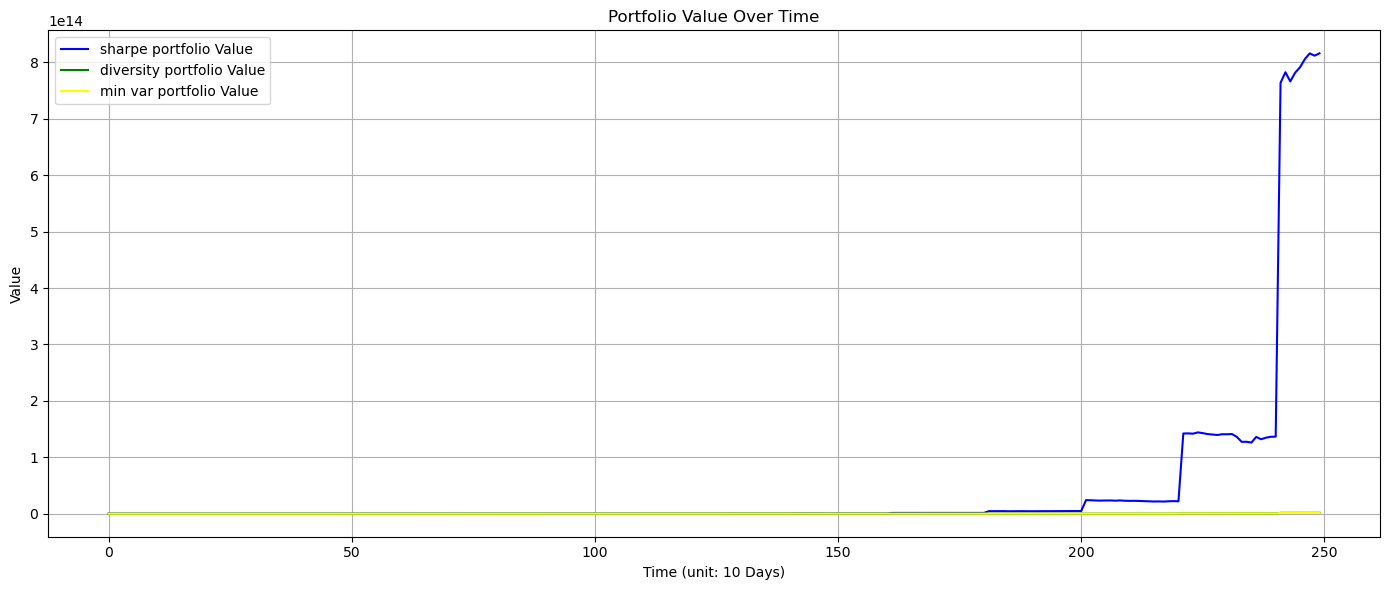

In [92]:
# Plotting
plt.figure(figsize=(14, 6))
plt.plot(sharpe_budget_history, label="sharpe portfolio Value", color='blue')
# plt.plot(calmar_budget_history, label="calmar Portfolio Value", color='red')
plt.plot(diversity_budget_history, label="diversity portfolio Value", color='green')
# plt.plot(max_var_budget_history, label="max var portfolio Value", color='peru')
plt.plot(min_var_budget_history, label="min var portfolio Value", color='yellow')
plt.title("Portfolio Value Over Time")
plt.xlabel("Time (unit: 10 Days)")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
# Compare results
for name, res in results.items():
    print(f"\nThe result of {name} is as follows\n")
    X, F, sharpe = res.opt.get("X", "F", "sharpe")
    F = F * [1, -1]
    max_sharpe = sharpe.argmax()

    '''
    # equal weights
    x = np.zeros((len(ticker), 1))
    x = x + 1.0/len(x)

    plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Pareto-Optimal Portfolio")
    plt.scatter(cov.diagonal() ** 0.5 * np.sqrt(250.0), mu, facecolor="none", edgecolors="black", s=30, label="Asset")
    plt.scatter(F[max_sharpe, 0], F[max_sharpe, 1], marker="x", s=100, color="red", label="Max Sharpe Portfolio")
    plt.scatter(np.sqrt(x.T @ cov @ x) * np.sqrt(250.0), x.T @ mu, marker="*", s=100, color="green", label="Equal weights")
    plt.legend()
    plt.xlabel("expected volatility")
    plt.ylabel("expected return")
    plt.show()

    plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Pareto-Optimal Portfolio")
    plt.scatter(F[max_sharpe, 0], F[max_sharpe, 1], marker="x", s=100, color="red", label="Max Sharpe Portfolio")
    plt.legend()
    plt.xlabel("expected volatility")
    plt.ylabel("expected return")
    plt.show()
    '''
    x = X[max_sharpe].T

    print("Best Sharpe: \nReturn     = ", x.T @ mu)
    print("Volatility = ", np.sqrt(x.T @ cov @ x) * np.sqrt(250.0))
    print("sharpo ratio = ", (x.T @ mu - 0.02)/(np.sqrt(x.T @ cov @ x) * np.sqrt(250.0)))


In [49]:
X, F, sharpe = res.opt.get("X", "F", "sharpe")
F = F * [1, -1]
max_sharpe = sharpe.argmax()

# equal weights
x = np.zeros((len(ticker), 1))
x = x + 1.0/len(x)

plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Pareto-Optimal Portfolio")
plt.scatter(cov.diagonal() ** 0.5 * np.sqrt(250.0), mu, facecolor="none", edgecolors="black", s=30, label="Asset")
plt.scatter(F[max_sharpe, 0], F[max_sharpe, 1], marker="x", s=100, color="red", label="Max Sharpe Portfolio")
plt.scatter(np.sqrt(x.T @ cov @ x) * np.sqrt(250.0), x.T @ mu, marker="*", s=100, color="green", label="Equal weights")
plt.legend()
plt.xlabel("expected volatility")
plt.ylabel("expected return")
plt.show()

plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Pareto-Optimal Portfolio")
plt.scatter(F[max_sharpe, 0], F[max_sharpe, 1], marker="x", s=100, color="red", label="Max Sharpe Portfolio")
plt.legend()
plt.xlabel("expected volatility")
plt.ylabel("expected return")
plt.show()

NameError: name 'res' is not defined

In [51]:
allocation = {name: w for name, w in zip(data.columns, X[max_sharpe])}
allocation = sorted(allocation.items(), key=operator.itemgetter(1), reverse=True)

print("Allocation With Best Sharpe")
for name, w in allocation:
    print(f"{name:<5} {w}")

AttributeError: module 'pandas_datareader.data' has no attribute 'columns'

In [53]:
for al in allocation:
    if al[1] <= 1e-2:
        allocation.remove(al)

col_name = []
w1 = []
for name, w in allocation:
    col_name.append(name)
    w1.append(w)
    
fig1, ax1 = plt.subplots()
ax1.pie(w1, labels=col_name, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

NameError: name 'allocation' is not defined

In [55]:
x = np.zeros((len(ticker), 1))
x = x + 1.0/len(x)

print("For equal weights: \nReturn     = ", (x.T @ mu)[0])
print("Volatility = ", (np.sqrt(x.T @ cov @ x) * np.sqrt(250.0))[0][0])

For equal weights: 
Return     =  0.11474887960744226
Volatility =  0.194630738676453


In [57]:
x = X[max_sharpe].T

print("Best Sharpe: \nReturn     = ", x.T @ mu)
print("Volatility = ", np.sqrt(x.T @ cov @ x) * np.sqrt(250.0))

NameError: name 'X' is not defined

In [64]:
import numpy as np
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.optimize import minimize
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.repair import Repair

class PortfolioProblem(ElementwiseProblem):
    def __init__(self, mu, cov, risk_free_rate=0.02, **kwargs):
        super().__init__(
            n_var=len(mu),
            n_obj=2,
            xl=0.0,
            xu=1.0,
            **kwargs
        )
        self.mu = mu
        self.cov = cov
        self.risk_free_rate = risk_free_rate

    def _evaluate(self, x, out, *args, **kwargs):
        exp_return = x @ self.mu
        exp_risk   = np.sqrt(x.T @ self.cov @ x) * np.sqrt(250.0)
        sharpe     = (exp_return - self.risk_free_rate) / exp_risk
        out["F"]   = [exp_risk, -exp_return]
        out["sharpe"] = sharpe

class PortfolioRepair(Repair):
    def _do(self, problem, X, **kwargs):
        X[X < 1e-3] = 0
        return X / X.sum(axis=1, keepdims=True)

# Compute mu, cov from your data
mu  = calculate_expected_returns(current_data)
cov = calculate_covariance_matrix(current_data)

# Problem definition
problem = PortfolioProblem(mu, cov)

# Reference directions for MOEA/D 
ref_dirs = get_reference_directions("uniform", 2, n_partitions=100)

# MOEA/D algorithm setup
algorithm = MOEAD(
    ref_dirs,
    n_neighbors=20,
    prob_neighbor_mating=0.7,
    repair=PortfolioRepair()
)

# Run optimization
res = minimize(problem, algorithm, seed=1, verbose=False)

# Extract and select optimal portfolio
X, F, sharpe = res.opt.get("X", "F", "sharpe")
F = F * [1, -1]
max_sharpe_idx = sharpe.argmax()
optimal_weights = X[max_sharpe_idx]

# Hypervolume (optional)
HVindex = calculate_HV(F)


C:\Users\kaomi\AppData\Local\Temp\ipykernel_18768\4236682315.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  ind_er = current_data.resample('Y').last().pct_change().mean()


HV 0.022752022831910097
